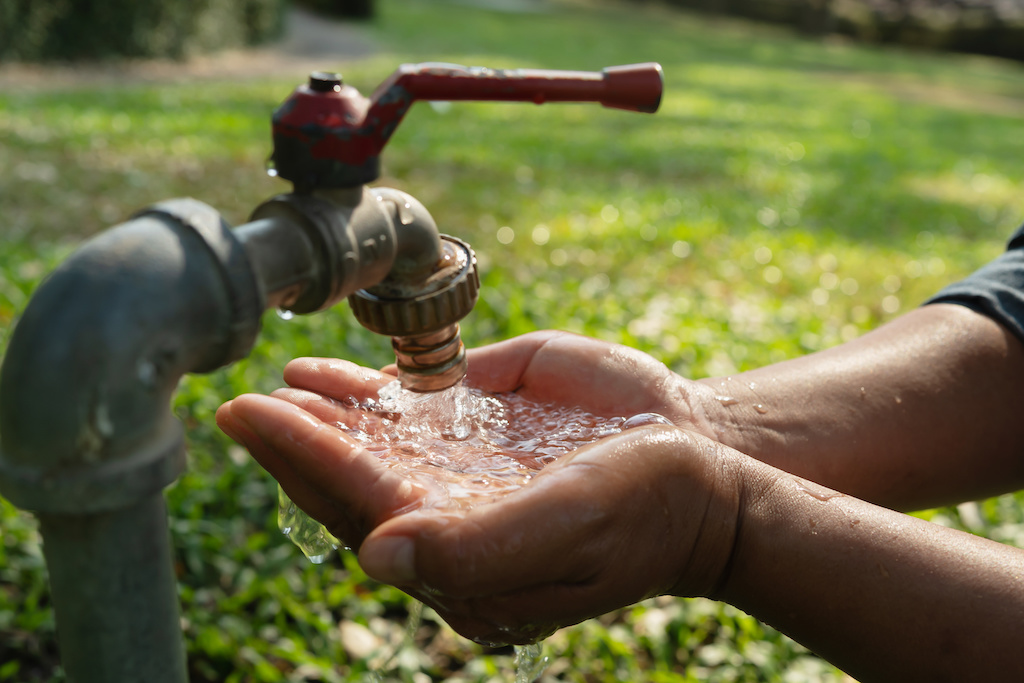
Photo by <a href="https://stock.adobe.com/contributor/203603884/lovelyday12?load_type=author&prev_url=detail" >lovelyday12</a> on Adobe Stock

# Phase 3 Project: *Tanzanian Water Pump Conditions Classification Model*

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: July 15th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify which water pumps in Tanzania are functional or in need of repair based on a variety of conditions and information on the pump

This is an asssignment for learning purposes. The Tanzanian Ministry of Water is not involved with this assignment in any way.

# Overview and Business Understanding

In the United States, most of us take for granted that we always have access to clean and safe water. But for hundreds of millions of people across the world, clean water is anything but guaranteed. One nation that is struggling with water insecurity is Tanzania, where as much as half the country–over 20 million people–<a href="https://lifewater.org/blog/tanzania-water-crisis-facts/" >do not have access to safe drinking water.</a><br>
<br>
In order to combat this crisis, <a href="http://taarifa.org/" >Taarifa</a> and the <a href="http://maji.go.tz/" >Tanzanian Ministry of Water </a> (TMW) have teamed up to gather data on the nations many water pumps - the primary source of safe drinking water for most Tanzanians. Using this data, I build a classification model that predicts whether a water pump is functional or needs attention (either non-functional or in need of repair).<br>
<br>
Using this model, the TMW will be able to improve their efficiency in repairing dysfunctional water pumps, and improve access to clean drinking water for millions of people.<br>
<br>
A note on scoring metrics: The TMW has not made it explicitly clear to us what the model will be used for. As such, we'll assume that the model will be used for both inferential purposes (i.e. to see which features are most deterministic in producing each condition), and for predictive purposes (i.e. to be able to predict the condition of a water pump based on the data on it).

Taking this assumption on the predictive purposes of the model, it's not clear which class label(s) is the most important to achieve high precision or recall scores on. For example, it may be that the TMW would like a high recall score for the functional water pumps, so they don't dispatch precious resources to pumps that are actually functional. It could also be the case that they want a high recall score for non-functional water pumps so that they can dispatch repair teams as quickly as possible for all non-functional pumps in Tanzania. Given the ambiguity here, we will prioritize a balance between precision and recall across classes and prioritize overall accuracy as the deciding metric when determining the best model.

Additionally, the competition will ultimately judge $\hat{y}$ submissions based on their classification rates, which is equal to the percentage of rows in $\hat{y}$ that match the actual y_test labels. This is equivalent to the accuracy score.

<br>

# Data Understanding

This data was obtained from Taarifa, "an open source platform for the crowd sourced reporting and triaging of infrastructure related issues", who aggregated the data from the Tanzanian Ministry of Water. I obtained this dataset from <a href="https://www.drivendata.org"> drivendata.org </a>as part of their competition entitled <a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/"> "Pump it Up: Data Mining the Water Table"</a>. The provided data was pre-split into training and testing data. As this dataset is part of a competition, labels were provided for the training data only. The training dataset contains 59,400 rows and 40 columns, while the testing dataset contains 14,850 rows.

There are three unique dependent variables in this dataset, which means that this is a multiclass classification model. The three labels are: 'functional', 'funtional needs repair', and 'non functional'. These labels are encoded as 0, 1, and 2, respectively, in the model.

<br>

# Exploratory Data Analysis

### Description of columns

**amount_tsh** - Total static head (amount water available to waterpoint)<br>
**date_recorded** - The date the row was entered<br>
**funder** - Who funded the well<br>
**gps_height** - Altitude of the well<br>
**installer** - Organization that installed the well<br>
**longitude** - GPS coordinate<br>
**latitude** - GPS coordinate<br>
**wpt_name** - Name of the waterpoint if there is one<br>
**basin** - Geographic water basin<br>
**subvillage** - Geographic location<br>
**region** - Geographic location<br>
**region_code** - Geographic location (coded)<br>
**district_code** - Geographic location (coded)<br>
**lga** - Geographic location<br>
**ward** - Geographic location<br>
**population** - Population around the well<br>
**public_meeting** - True/False<br>
**recorded_by** - Group entering this row of data<br>
**scheme_management** - Who operates the waterpoint<br>
**scheme_name** - Who operates the waterpoint<br>
**permit** - If the waterpoint is permitted<br>
**construction_year** - Year the waterpoint was constructed<br>
**extraction_type** - The kind of extraction the waterpoint uses<br>
**extraction_type_group** - The kind of extraction the waterpoint uses<br>
**extraction_type_class** - The kind of extraction the waterpoint uses<br>
**management** - How the waterpoint is managed<br>
**management_group** - How the waterpoint is managed<br>
**payment** - What the water costs<br>
**payment_type** - What the water costs<br>
**water_quality** - The quality of the water<br>
**quality_group** - The quality of the water<br>
**quantity** - The quantity of water<br>
**quantity_group** - The quantity of water<br>
**source** - The source of the water<br>
**source_type** - The source of the water<br>
**source_class** - The source of the water<br>
**waterpoint_type** - The kind of waterpoint<br>
**waterpoint_type_group** - The kind of waterpoint<br>
<br>

### Description of labels

**functional** - the waterpoint is operational and there are no repairs needed<br>
**functional needs repair** - the waterpoint is operational, but needs repairs<br>
**non functional** - the waterpoint is not operational

### Import libraries, packages and modules

In [103]:
import numpy as np
import pandas as pd
import folium

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix
from yellowbrick.classifier import ROCAUC

import pickle
import joblib
from joblib import parallel_backend
from sklearn import set_config
set_config(display='diagram')

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('darkgrid')

In [2]:
# Load up the data

# Submission format example for competition
submission_format_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv')

# Load in X_train dataframe
X_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')

# Load in y_train dataframe
y_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

# Load in X_test dataframe (for competition purposes only - will not be used as X_test dataframe for 
# train/test split purposes as labels were not included)
X_test_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv')

In [3]:
# Preview features dataframe

print(X_train_df.shape)
X_train_df.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Preview target variables dataframe

y_train_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
# Preview distribution of target variables

print(y_train_df['status_group'].value_counts(), '\n')
print(y_train_df['status_group'].value_counts(normalize=True))

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64 

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


> **Remarks:**
> - The dataset is somewhat imbalanced, with 54% in the 'functional' group, 38% in the 'non functional' group, and the remaining 7% in the 'functional needs repair' group

In [6]:
# Preview features dataframe info

X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

> **Remarks:**
> - 7 int features, 3 float features, 30 object features
> - Most features are nominal categorical descriptors, with many of the numerical descriptors actually being location identification variables
> - Some features with a lot of missing values: `scheme_name`, `funder`, `installer`, `scheme_management`


In [7]:
columns_isna = [column for column in X_train_df.columns if X_train_df[column].isna().sum() > 0]
    
print('Features with missing values:')
X_train_df[columns_isna].isna().sum()

Features with missing values:


funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [8]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


> **Remarks:**
> - No missing `status_group` labels

In [9]:
X_train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Visualization of Water Pumps

To get an idea of the distribution of the different water pumps and their respective conditions, we'll build a folium map with each marker color-coded with the pump's condition. This may also give us some insight into any geographic trends that may be influencing the condition of the pumps.

In [10]:
# Coordinates of Dodoma - capital of Tanzania
dodoma_lat = -6.1630
dodoma_long = 35.7516

num_markers = 250

# Create a map of the area
base_map = folium.Map([dodoma_lat, dodoma_long], zoom_start=5.5)

# Add random sample of 300 water pumps to map, colored by water pump condition
for index, pump in X_train_df.sample(n=num_markers).iterrows():
    lat = pump.latitude
    long = pump.longitude
    if y_train_df.iloc[index].status_group == 'functional':
        color = 'green'
    elif y_train_df.iloc[index].status_group == 'functional needs repair':
        color = 'orange'
    elif y_train_df.iloc[index].status_group == 'non functional':
        color = 'red'
    marker = folium.Marker(location=[lat, long])
    marker.add_to(base_map)
    popup_text = f"Condition: {y_train_df.iloc[index].status_group.capitalize()}"
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup, icon=folium.Icon(color))
    marker.add_to(base_map)
base_map

> **Remarks:**
> - There doesn't appear to be any obvious geographic trends affecting pump condition in the distribution of pumps across Tanzania

<br>

# Initial Preprocessing

There's a variety of initial preprocessing we need to perform before we do a train/test split, including dropping duplicate columns and dropping or transforming otherwise useless or cumbersome columns. Any preprocessing that could cause data leakage will be saved for the ColumnTransformer.

### Drop `id` column of X_train and y_train

ID numbers are not necessary for modeling purposes (I am assuming they carry no predictive value)

In [11]:
X_train_df.drop(columns='id', inplace=True)

y_train_df.drop(columns='id', inplace=True)

### Convert `status_group` column of y_train from ternary object to ternary int: 0 if 'functional', 1 if 'functional needs repair', and 2 if 'non functional'

In order for the models to work, the target labels need to be in numeric form

In [12]:
y_train_df.replace({'functional': 0, 'functional needs repair': 1, 'non functional': 2}, inplace=True)

# Sanity check
y_train_df.value_counts()

status_group
0               32259
2               22824
1                4317
dtype: int64

### Drop additional valueless variables:

1. **`date_recorded`** - The date the row was entered<br>
Unlikely to carry any predictive value - date of construction is already captured in `construction_year`<br>
<br>
2. **`longitude`** and **`latitude`** - GPS coordinates<br>
Such specific location information is unlikely to carry much predictive value, and substantial location information is already captured in other columns<br>
<br>
3. **`num_private`** - Undisclosed<br>
It is undisclosed what this feature means, but 58,643 of the 59,400 rows all contain '0' for this feature and many of the values of the feature have only one corresponding row, so it would be cumbersome to work with and is unlikely to carry any predictive value anyway<br>
<br>
4. **`region`** - Geographic location<br>
Essentially the same information as `region_code` column, but with what appears to be slighly less granularity. Since `region_code` contains more granularity, we'll keep that one.<br>
<br>
5. **`wpt_name`** - Name of the waterpoint if there is one<br>
Unlikely to carry much predictive value — most of the values for this feature are unique to one row or have value 'none', and substantial waterpoint information is captured in other variables<br>
<br>
6. **`subvillage`** - Geographic location<br>
May potentially carry some predictive value, however substantial location information is already contained in other columns, and numerous subvillages exist with only a single row which would be tricky to deal with while modeling. Additionally, 371 missing values exist for this column.<br>
<br>
7. **`ward`** - Geographic location<br>
Contains over 2k unique values, many with only one corresponding row, which would be cumbersome to work with. Additionally, location information is captured in other variables.<br>
<br>
8. **`recorded_by`** - Group entering this row of data<br>
All rows have same value for this feature: 'GeoData Consultants Ltd'<br>
<br>
9. **`scheme_management`** and **`management_group`**- Who operates the waterpoint / How the waterpoint is managed<br>
`management`, `management_group`, and `scheme_management`, all contain largely the same information, with variations on the level of granularity. Since `management` contains more granular information than `management_group` and is missing fewer values than `scheme_management`, we'll keep that one.<br>
<br>
10. **`scheme_name`** - Who operates the waterpoint<br>
Feature contains 28,166 missing values, plus 664 where the value is equal to 'None'. Additionally, many of the values for this feature have only one corresponding row, and information on the operator is also captured in the `management` feature which has no missing values. As such, we'll drop this feature, though there may be a small amount of predictive value in it.<br>
<br>
11. **`extraction_type_group`** and **`extraction_type_class`** - The kind of extraction the waterpoint uses<br>
`extraction_type`, `extraction_type_group`, and `extraction_type_class` all contain largely the same information, with variations on the level of granularity. Since `extraction_type` contains the most granular information, we'll keep that one.<br>
<br>
12. **`payment`** - What the water costs<br>
Exact duplicate of information in column `payment_type`<br>
<br>
13. **`quality_group`** - The quality of the water<br>
Essentially the same information as `water_quality` column, with less granularity. Since `water_quality` contains more granularity, we'll keep that one.<br>
<br>
14. **`quantity_group`** - The quantity of water<br>
Exact duplicate of information in column `quantity`<br>
<br>
15. **`source_type`** and **`source_class`** - The source of the water<br>
`source`, `source_type`, and `source_class` all contain largely the same information, with variations on the level of granularity. Since `source` contains the most granular information, we'll keep that one.<br>
<br>
16. **`waterpoint_type_group`** - The kind of waterpoint<br>
Essentially the same information as `waterpoint_type` column, with less granularity. Since `waterpoint_type` contains more granularity, we'll keep that one.

In [13]:
columns_to_drop = ['date_recorded', 'longitude', 'latitude', 'num_private', 'region', 'wpt_name', 
                   'subvillage', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
                   'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 
                   'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

X_train_df.drop(columns=columns_to_drop, inplace=True)

# Preview new dataframe
X_train_df

,amount_tsh,funder,gps_height,installer,basin,region_code,district_code,lga,population,public_meeting,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type
0,6000.0,Roman,1390,Roman,Lake Nyasa,11,5,Ludewa,109,True,False,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe
1,0.0,Grumeti,1399,GRUMETI,Lake Victoria,20,2,Serengeti,280,NaN,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,25.0,Lottery Club,686,World vision,Pangani,21,4,Simanjiro,250,True,True,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple
3,0.0,Unicef,263,UNICEF,Ruvuma / Southern Coast,90,63,Nanyumbu,58,True,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
4,0.0,Action In A,0,Artisan,Lake Victoria,18,1,Karagwe,0,True,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Germany Republi,1210,CES,Pangani,3,5,Hai,125,True,True,1999,gravity,water board,per bucket,soft,enough,spring,communal standpipe
59396,4700.0,Cefa-njombe,1212,Cefa,Rufiji,11,4,Njombe,56,True,True,1996,gravity,vwc,annually,soft,enough,river,communal standpipe
59397,0.0,NaN,0,NaN,Rufiji,12,7,Mbarali,0,True,False,0,swn 80,vwc,monthly,fluoride,enough,machine dbh,hand pump
59398,0.0,Malec,0,Musa,Rufiji,1,4,Chamwino,0,True,True,0,nira/tanira,vwc,never pay,soft,insufficient,shallow well,hand pump


### Convert `region_code` and `district_code` to datatype 'object'

These features are actually nominal categorical features describing location, despite being in integer form. Converting them to datatype 'object' will make them easier to work with when it comes time to build pipelines.

In [14]:
X_train_df['region_code'] = X_train_df['region_code'].astype('object')
X_train_df['district_code'] = X_train_df['district_code'].astype('object')

### Impute missing values in `public_meeting` and `permit` with "Unknown" and convert to object datatype

These are two of the four columns remaining that have missing values. Rather than imputing a 0 or 1 for these values, we'll add an "Unknown" value and then one-hot encode the columns.

In [15]:
columns_isna = [column for column in X_train_df.columns if X_train_df[column].isna().sum() > 0]
    
print('Features with missing values:')
X_train_df[columns_isna].isna().sum()

Features with missing values:


funder            3635
installer         3655
public_meeting    3334
permit            3056
dtype: int64

In [16]:
# Replace NaN values with "Unknown"
X_train_df[['public_meeting', 'permit']] = X_train_df[['public_meeting', 'permit']].fillna(value='Unknown')

# Convert boolean values in columns to object datatype
X_train_df['public_meeting'].replace({False: 'False', True: 'True'}, inplace=True)
X_train_df['permit'].replace({False: 'False', True: 'True'}, inplace=True)

In [17]:
columns_isna = [column for column in X_train_df.columns if X_train_df[column].isna().sum() > 0]
    
print('Features with missing values:')
X_train_df[columns_isna].isna().sum()

Features with missing values:


funder       3635
installer    3655
dtype: int64

### Condense `funder` and `installer` columns

These are the other two columns that contain missing values.

The number of unique values in these columns would make them cumbersome to work with - they have nearly 2,000 unique values each. We're going to keep the top 49 for each column, and condense the remaining into "Other/Unknown".

Each column also has some values of "0", which we will assume is unknown and include them in the "Other/Unknown" category.

In [18]:
print(X_train_df.funder.value_counts(dropna=False))
print()
print(X_train_df.installer.value_counts(dropna=False))

Government Of Tanzania    9084
NaN                       3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1898, dtype: int64

DWE                17402
NaN                 3655
Government          1825
RWE                 1206
Commu               1060
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2146, dtype: int64


In [19]:
# Fill NaNs with "Other/Unknown"
X_train_df['funder'].fillna(value='Other/Unknown', inplace=True)
X_train_df['installer'].fillna(value='Other/Unknown', inplace=True)

# Replace "0" values with "Other/Unknown"
X_train_df['funder'].replace(to_replace='0', value='Other/Unknown', inplace=True)
X_train_df['installer'].replace(to_replace='0', value='Other/Unknown', inplace=True)

# Replace all funder and installer values that are not among the top 49 most common with "Other/Unknown"
funder_indexes = X_train_df.funder.value_counts()[50:].index
installer_indexes = X_train_df.installer.value_counts()[50:].index

X_train_df['funder'].replace(to_replace=funder_indexes, value='Other/Unknown', inplace=True)
X_train_df['installer'].replace(to_replace=installer_indexes, value='Other/Unknown', inplace=True)

In [20]:
print(f"Unique values: {len(X_train_df.funder.value_counts(dropna=False))}")
print(X_train_df.funder.value_counts(dropna=False)[:5])
print()
print(f"Unique values: {len(X_train_df.installer.value_counts(dropna=False))}")
print(X_train_df.installer.value_counts(dropna=False)[:5])

Unique values: 50
Other/Unknown             22129
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
Name: funder, dtype: int64

Unique values: 50
Other/Unknown    22242
DWE              17402
Government        1825
RWE               1206
Commu             1060
Name: installer, dtype: int64


There should be no more missing values now

In [21]:
print(f"Missing values in X_train_df: {X_train_df.isna().sum().sum()}")

Missing values in X_train_df: 0


### Impute `construction_year` column placeholder values with results of a linear regression

A value of '0' seems to be a placeholder for "Unknown" for this column for about one-third of the values. This is a lot of values, but the construction year of the water pump intuitively seems like it could contain a good deal of value for the functionality of the pump. Rather than drop all those rows or the entire column, or impute a blunt value like the median or mean, we'll linear regress on the column where the values are not 0, and then use that array to replace the values where they are equal to 0. The function `linreg_construction_year_0s` below performs this operation.

Note: This option will cause a small amount of data leakage, because we have not performed the train/test split yet. We could add this function as a FunctionTransformer within our ColumnTransformer that we'll make, but this would mean that we need to perform this linear regression on every fold of every model that we run, which would be computationally expensive. We'll take the trade-off and accept this small amount of data leakage.

In [22]:
def linreg_construction_year_0s(df):
    linreg = LinearRegression()
    
    con_year_df = pd.get_dummies(df, drop_first=True)
    
    con_year_df_0 = con_year_df[con_year_df['construction_year'] == 0]
    con_year_df_not_0 = con_year_df[con_year_df['construction_year'] != 0]
    
    con_year_X = con_year_df_not_0.drop(columns='construction_year')
    con_year_y = con_year_df_not_0['construction_year']
    
    linreg.fit(con_year_X, con_year_y)

    round_array = np.vectorize(round)
    con_year_preds = round_array(linreg.predict(con_year_df_0.drop(columns='construction_year')))
    
    replacements_df = pd.DataFrame(con_year_preds, 
                                   index=con_year_df_0.index, 
                                   columns=['construction_year'])
    
    for i in replacements_df.index:
        df.loc[i, 'construction_year'] = replacements_df.loc[i, 'construction_year']

In [23]:
linreg_construction_year_0s(X_train_df)

In [24]:
X_train_df.construction_year.value_counts()[:10]

2000    2983
2008    2968
2010    2945
2009    2736
2007    2627
1995    2524
2006    2417
2004    2159
2002    2146
2003    2078
Name: construction_year, dtype: int64

> **Remarks:**
> No more 0s!

In [25]:
# Preview final preprocessed dataframe
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   funder             59400 non-null  object 
 2   gps_height         59400 non-null  int64  
 3   installer          59400 non-null  object 
 4   basin              59400 non-null  object 
 5   region_code        59400 non-null  object 
 6   district_code      59400 non-null  object 
 7   lga                59400 non-null  object 
 8   population         59400 non-null  int64  
 9   public_meeting     59400 non-null  object 
 10  permit             59400 non-null  object 
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  object 
 13  management         59400 non-null  object 
 14  payment_type       59400 non-null  object 
 15  water_quality      59400 non-null  object 
 16  quantity           594

### Visualization of distribution of numeric features

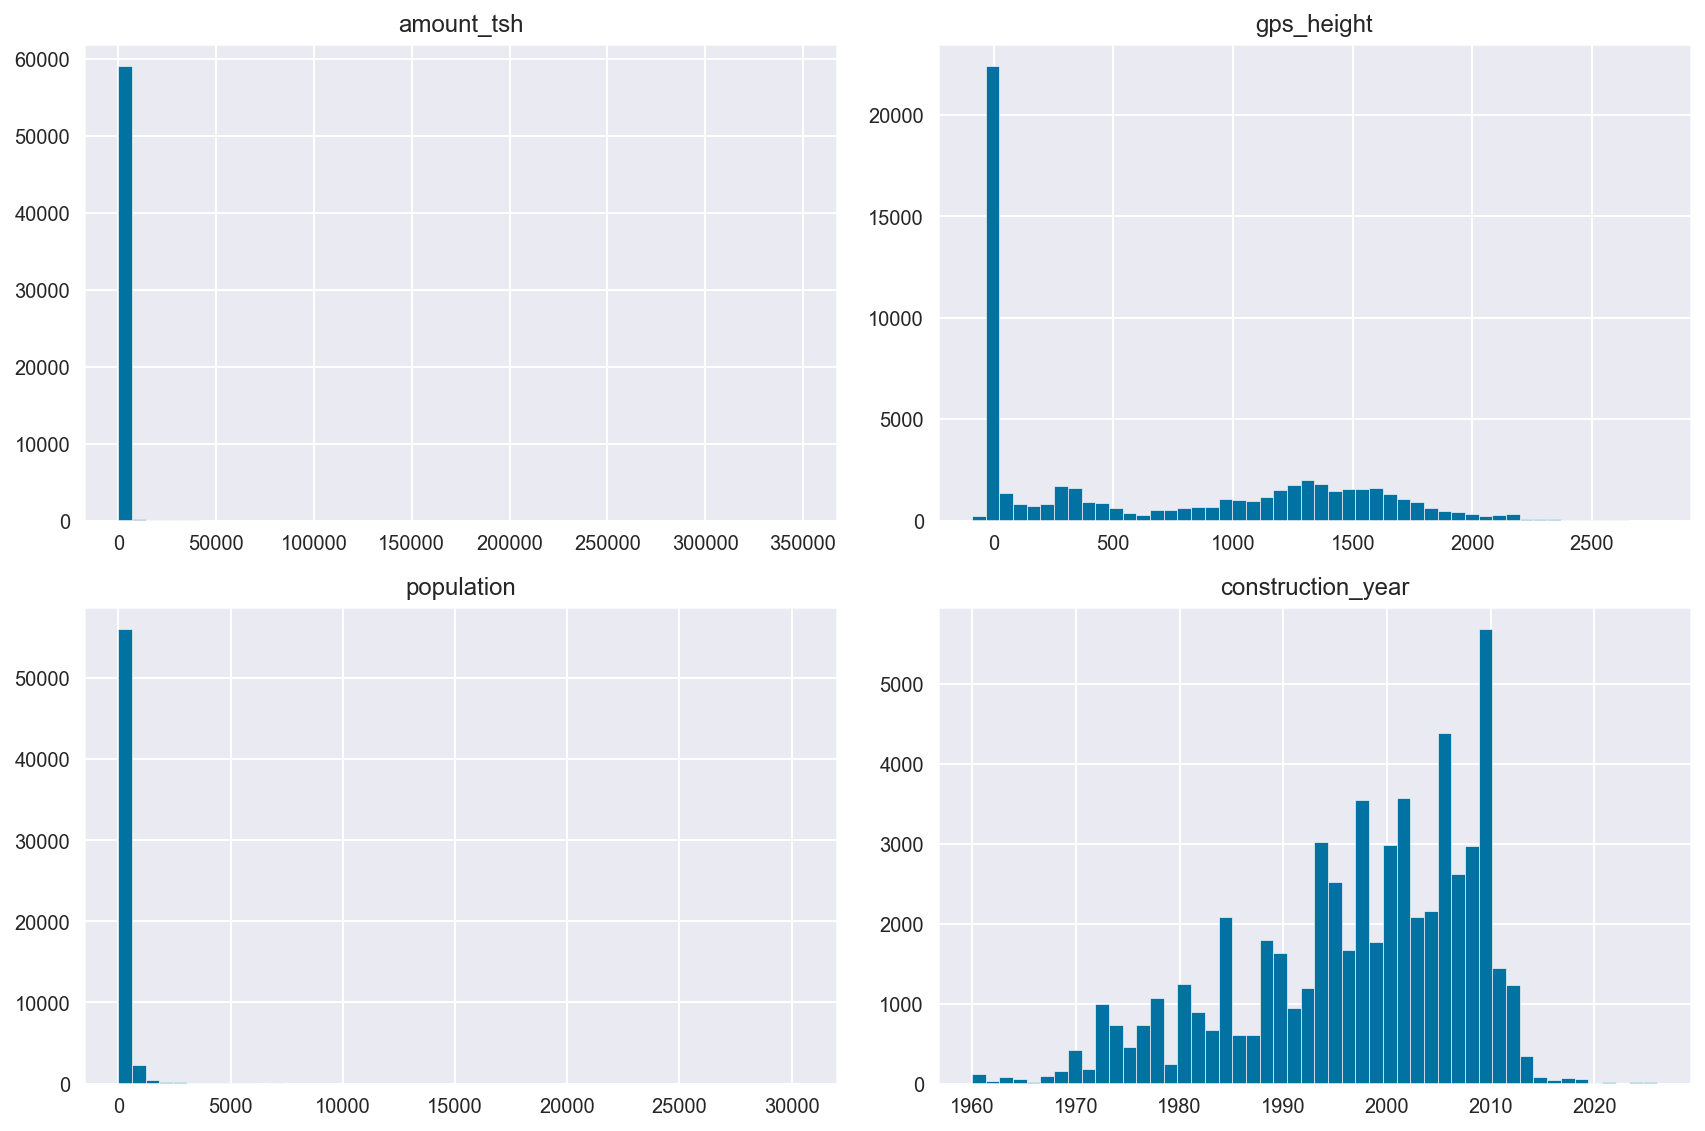

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

numericals = [column for column in X_train_df.select_dtypes(['int', 'float']).columns]

for feature, ax in zip(numericals, axes.flatten()):
    ax.hist(X_train_df[feature], bins=50)
    ax.set_title(feature)
    
fig.tight_layout()

> **Remarks:**
> Three of our numerical features are extremely right-skewed. Let's log-transform these features to make them more normally distributed, which may improve model performance for certain kinds of models such as logistic regression.

Before we log transform, it looks like we have some negative values in `gps_height`. The lowest value there is -90; we'll add a constant of 91 for this column, and a constant of 1 for `amount_tsh` and `population` to account for the values of 0 there

In [27]:
X_train_df.gps_height.value_counts().sort_index()[:5]

-90    1
-63    2
-59    1
-57    1
-55    1
Name: gps_height, dtype: int64

In [28]:
X_train_df['gps_height'] = X_train_df['gps_height'].apply(lambda x: x + 91)
X_train_df['amount_tsh'] = X_train_df['amount_tsh'].apply(lambda x: x + 1)
X_train_df['population'] = X_train_df['population'].apply(lambda x: x + 1)

In [29]:
X_train_df[['amount_tsh', 'gps_height', 'population']] = \
X_train_df[['amount_tsh', 'gps_height', 'population']].apply(np.log1p)

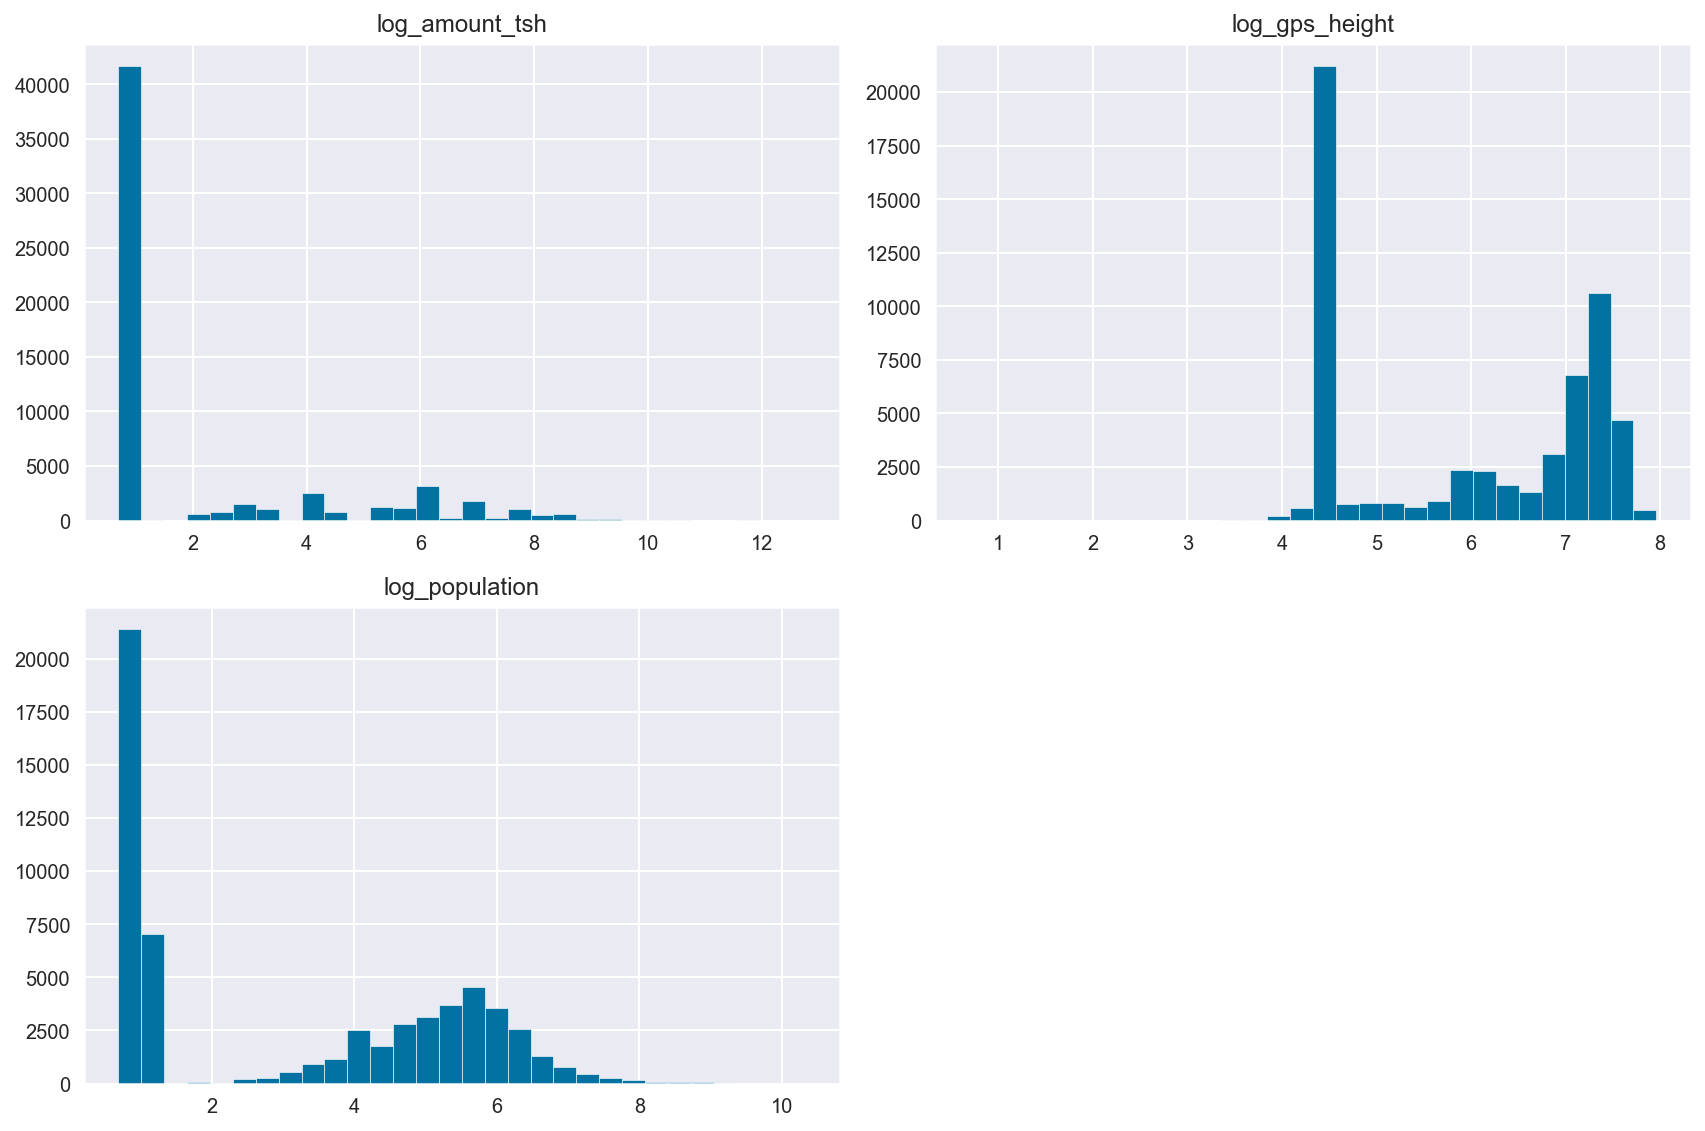

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

numericals = [column for column in X_train_df.select_dtypes(['int', 'float']).columns]

for feature, ax in zip(numericals, axes.flatten()):
    ax.hist(X_train_df[feature], bins=30)
    ax.set_title('log_' + feature)
    if feature == 'construction_year':
        ax.remove()
    
fig.tight_layout()

> **Remarks:**
> - Distributions look a bit more normal at least

<br>

# Train/Test Split

As we saw above, this is an unbalanced dataset, so we'll set stratify=y to ensure an even balance of labels between train and test sets. We'll use an unusually large train size of 0.5 in order to reduce the computatationally complexity and runtime of our models. With nearly 60,000 rows, we can afford to only use half.

In [31]:
X = X_train_df.copy()
y = y_train_df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, stratify=y, random_state=42)

In [32]:
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Testing set: {X_test.shape}, {y_test.shape}')
print()

# Check that target variables are evenly distributed between y_train and y_test
print(f'Training set: {y_train.value_counts(normalize=True)}')
print(f'Testing set: {y_test.value_counts(normalize=True)}')

Training set: (29700, 19), (29700, 1)
Testing set: (29700, 19), (29700, 1)

Training set: status_group
0               0.543064
2               0.384242
1               0.072694
dtype: float64
Testing set: status_group
0               0.543098
2               0.384242
1               0.072660
dtype: float64


<br>

# Create ColumnTransformer to Preprocess Data

**Rundown:**
- Standard scale numerical columns: `amount_tsh`, `gps_height`, `population`, and `construction_year`<br>
<br>
- One hot encode categorical columns

In [33]:
numeric_pipeline = Pipeline([ 
    ('standard_scale', StandardScaler())
    ])

categorical_pipeline = Pipeline([
    ('one_hot_encode', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
     ])

# Numeric columns
ss_cols = list(X_train.select_dtypes(['int', 'float']).columns)
# Categorical columns
ohe_cols = list(X_train.select_dtypes('object').columns)

ct = ColumnTransformer([
    ('ss_pipe', numeric_pipeline, ss_cols), 
    ('ohe_pipe', categorical_pipeline, ohe_cols)
    ], 
    remainder='passthrough')

ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('ss_pipe',
                                 Pipeline(steps=[('standard_scale',
                                                  StandardScaler())]),
                                 ['amount_tsh', 'gps_height', 'population',
                                  'construction_year']),
                                ('ohe_pipe',
                                 Pipeline(steps=[('one_hot_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['funder', 'installer', 'basin', 'region_code',
                                  'district_code', 'lga', 'public_meeting',
                                  'permit', 'extraction_type', 'management',
                                  'payment_type', 'water_quality', 'quantity',
                                  'source', 'waterpoint_type'])])

In [34]:
pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())

,ss_pipe__amount_tsh,ss_pipe__gps_height,ss_pipe__population,ss_pipe__construction_year,ohe_pipe__funder_Adra,ohe_pipe__funder_Amref,ohe_pipe__funder_Ces(gmbh),ohe_pipe__funder_Danida,ohe_pipe__funder_Ded,ohe_pipe__funder_Dh,...,ohe_pipe__source_river,ohe_pipe__source_shallow well,ohe_pipe__source_spring,ohe_pipe__source_unknown,ohe_pipe__waterpoint_type_communal standpipe,ohe_pipe__waterpoint_type_communal standpipe multiple,ohe_pipe__waterpoint_type_dam,ohe_pipe__waterpoint_type_hand pump,ohe_pipe__waterpoint_type_improved spring,ohe_pipe__waterpoint_type_other
0,0.432587,-0.045338,-0.014029,0.512873,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.587908,0.924832,1.095390,1.141907,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.587908,-1.135658,-1.029639,-0.206023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.763613,0.851404,1.018730,-0.924919,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.587908,-1.135658,-1.029639,0.512873,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29695,-0.587908,-1.135658,-1.029639,0.333149,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29696,-0.587908,0.955898,0.903555,0.333149,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29697,2.352318,1.028023,0.350302,-1.194505,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29698,0.592049,0.215646,1.122550,-0.835057,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


> **Remarks:**
> Looks good to go!

<br>

# Create Function to Cross Validate and Print Model Scores

The below function performs a 5-fold cross validation and prints the accuracy, precision, recall, F1, and AUC scores for both the training and testing sets. For precision, recall, and F1, we print the macro averages. The macro average is the arithmetic mean of the respective metric across each of the class labels. For the AUC score, we use the One-vs-Rest algorithm, due to its computational efficiency.

We're also going to print classification reports on the testing data for each of our models. The difference between the cross-validated macro F1 scores and the testing weighted average F1 scores is that the latter weights the F1 scores by the proportion of the respective class label, while the former simply takes an arithmetic mean of the F1 scores of the three classes.

In [35]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays 
    using given pipeline and prints the training and cross_val scores
    '''
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    # This speeds up the processing
    with parallel_backend('threading', n_jobs=-1):
        # Pass in pipe to cross validate along with a feature list; keep standard 5-fold cross-validation
        results = cross_validate(pipe, X, y, cv=5, return_train_score=True, scoring=scoring)
    
    print(f"Training Accuracy: {round(results['train_accuracy'].mean(), 6)}")
    print(f"Cross_Val Accuracy: {round(results['test_accuracy'].mean(), 6)}")
    print('-'*40)
    print(f"Training Macro Precision: {round(results['train_precision_macro'].mean(), 6)}")
    print(f"Cross_Val Macro Precision: {round(results['test_precision_macro'].mean(), 6)}")
    print('-'*40)
    print(f"Training Macro Recall: {round(results['train_recall_macro'].mean(), 6)}")
    print(f"Cross_Val Macro Recall: {round(results['test_recall_macro'].mean(), 6)}")
    print('-'*40)
    print(f"Training Macro F1 Score: {round(results['train_f1_macro'].mean(), 6)}")
    print(f"Cross_Val Macro F1 Score: {round(results['test_f1_macro'].mean(), 6)}")
    print('-'*40)
    print(f"Training Macro AUC Score: {round(results['train_roc_auc_ovr'].mean(), 6)}")
    print(f"Cross_Val Macro AUC Score: {round(results['test_roc_auc_ovr'].mean(), 6)}")

<br>

# Baseline: Dummy Classifier

We'll start the modeling process with a baseline dummy model that classifies every row as the most common label in the dataset, which is 0: functional

In [36]:
steps=[('preprocessing', ct), 
       ('dc', DummyClassifier(strategy='most_frequent'))]

dummy_pipe = Pipeline(steps)

dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('dc', DummyClassifier(strategy='most_frequent'))])

In [37]:
# Ignore UndefinedMetricWarnings being thrown due to the model being a dummy classifier
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
# Ignore UserWarnings being thrown
warnings.filterwarnings('ignore', category=UserWarning)

print_cv_scores(dummy_pipe, X_train, y_train.values.ravel())

Training Accuracy: 0.543064
Cross_Val Accuracy: 0.543064
----------------------------------------
Training Macro Precision: 0.181021
Cross_Val Macro Precision: 0.181021
----------------------------------------
Training Macro Recall: 0.333333
Cross_Val Macro Recall: 0.333333
----------------------------------------
Training Macro F1 Score: 0.234626
Cross_Val Macro F1 Score: 0.234626
----------------------------------------
Training Macro AUC Score: 0.5
Cross_Val Macro AUC Score: 0.5


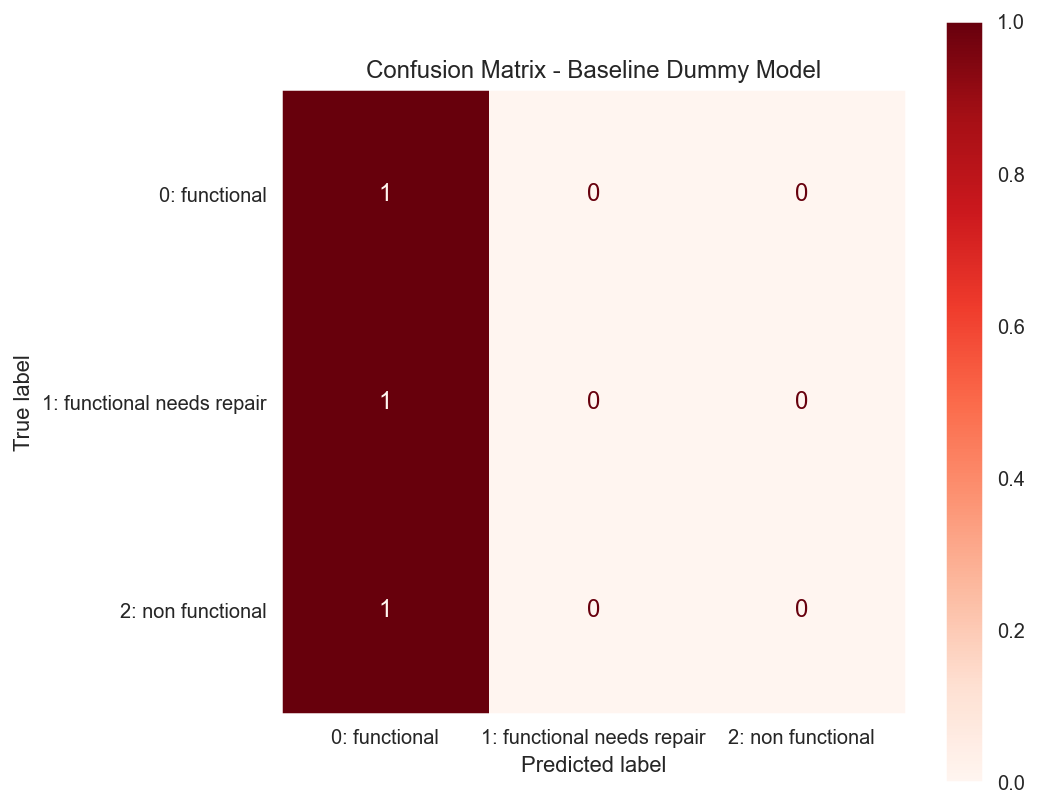



                            precision    recall  f1-score   support

             0: functional      0.543     1.000     0.704     16130
1: functional needs repair      0.000     0.000     0.000      2158
         2: non functional      0.000     0.000     0.000     11412

                  accuracy                          0.543     29700
                 macro avg      0.181     0.333     0.235     29700
              weighted avg      0.295     0.543     0.382     29700



In [38]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Define confusion matrix label names
class_names = ['0: functional', '1: functional needs repair', '2: non functional']

# Plot confusion matrix on testing data
plot_confusion_matrix(dummy_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Baseline Dummy Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = dummy_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - We can see that the dummy achieved a ~54% precision for class 0, since that is the proportion of class 0 in the dataset, and 0% precision for the remaining labels. The dummy model did not perform very well, to no one's surprise. This is just a baseline to compare future models against.

<br>

# Model 1.1: Logistic Regression Classifier, Iteration 1

Let's start the real modeling process with a vanilla LogisticRegression model

In [39]:
# Take all the default argument for LogisticRegression model
steps=[('preprocessing', ct), 
       ('logreg', LogisticRegression(random_state=42))]

lr_1_pipe = Pipeline(steps)

lr_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('logreg', LogisticRegression(random_state=42))])

In [40]:
# Ignore ConvergenceWarnings being thrown due to lack of convergence in gradient descent
warnings.filterwarnings('ignore', category=ConvergenceWarning)

print_cv_scores(lr_1_pipe, X_train, y_train.values.ravel())

Training Accuracy: 0.758519
Cross_Val Accuracy: 0.752189
----------------------------------------
Training Macro Precision: 0.708478
Cross_Val Macro Precision: 0.685938
----------------------------------------
Training Macro Recall: 0.577303
Cross_Val Macro Recall: 0.568874
----------------------------------------
Training Macro F1 Score: 0.597957
Cross_Val Macro F1 Score: 0.586705
----------------------------------------
Training Macro AUC Score: 0.860182
Cross_Val Macro AUC Score: 0.846195


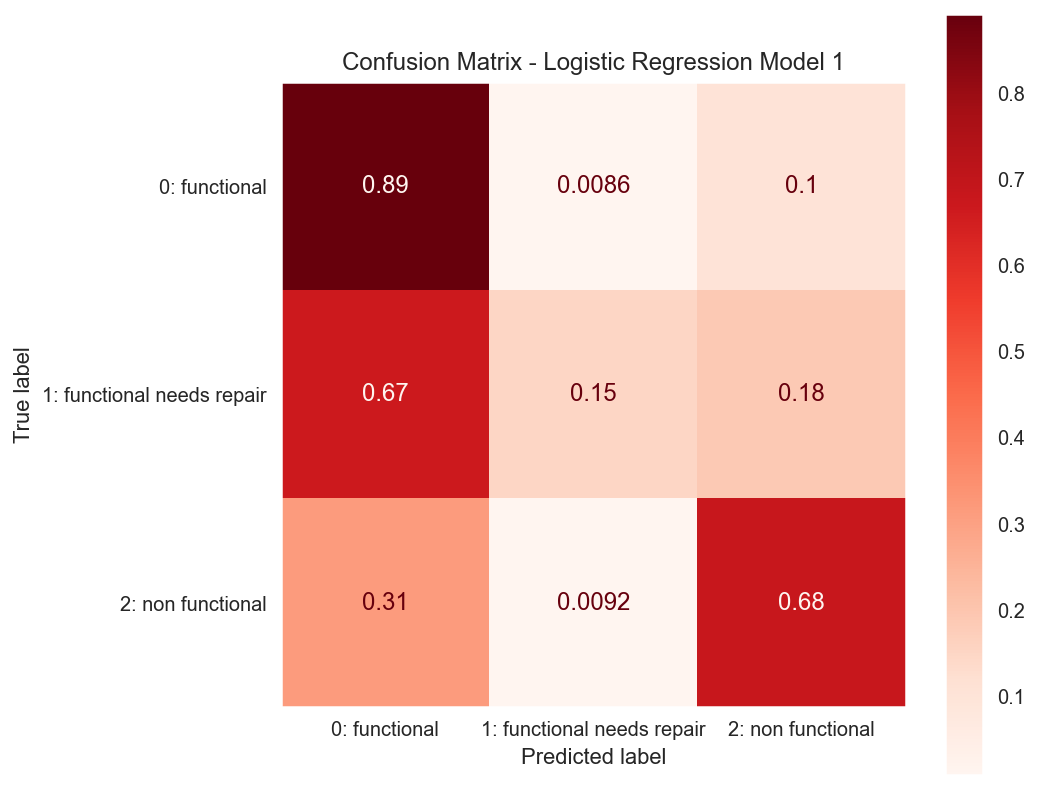



                            precision    recall  f1-score   support

             0: functional      0.742     0.891     0.810     16130
1: functional needs repair      0.571     0.150     0.237      2158
         2: non functional      0.793     0.678     0.731     11412

                  accuracy                          0.755     29700
                 macro avg      0.702     0.573     0.593     29700
              weighted avg      0.749     0.755     0.738     29700



In [41]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Define confusion matrix label names
class_names = ['0: functional', '1: functional needs repair', '2: non functional']

# Plot confusion matrix on testing data
plot_confusion_matrix(lr_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Logistic Regression Model 1')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = lr_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - We're not doing too bad with a vanilla LogisticRegression model. Over 75% cross-validated accuracy and nearly 59% macro F1 score. The weighted average F1 score on our testing data is nearly 74%. So far the model is most precise with non-functional water pumps, and has highest recall with functional water pumps.

<br>

# Model 1.2: Logistic Regression Classifier, Iteration 2

Let's try tuning some of the hyperparameters of the LogisticRegression model with a GridSearchCV. Specifically, we'll try to optimize the regularization strength, `C`, and the maximum number of iterations, `max_iter`, to improve the model.

In [42]:
# steps=[('preprocessing', ct), 
#        ('logreg', LogisticRegression(random_state=42))]

# lr_2_pipe = Pipeline(steps)

# pipe_grid = {'logreg__C': [12, 18, 24], 
#              'logreg__max_iter': [100, 200]}

# lr_2_gs_pipe = GridSearchCV(estimator=lr_2_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=5,  # 5-fold cross-validation
#                             n_jobs=-1,  # Speed up computational time by using all processors
#                             verbose=True)  # Print how many folds, candidates, and fits we're solving for

# with parallel_backend('threading', n_jobs=-1):
#     lr_2_gs_pipe.fit(X_train, y_train.values.ravel())

In [43]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/lr_2_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(lr_2_gs_pipe, f)

In [44]:
# Load in pickled object
with open('pickled_objects/lr_2_gs_pipe.pkl', 'rb') as f:
    lr_2_gs_pipe = joblib.load(f)
    
print(lr_2_gs_pipe.best_params_)

{'logreg__C': 12, 'logreg__max_iter': 200}


In [45]:
# Create new LogisticRegression classifier model with optimal hyperparameters found above
optimal_C = lr_2_gs_pipe.best_params_['logreg__C']
optimal_max_iter = lr_2_gs_pipe.best_params_['logreg__max_iter']

steps=[('preprocessing', ct), 
       ('logreg', LogisticRegression(C=optimal_C, max_iter=optimal_max_iter, random_state=42))]

lr_2_pipe = Pipeline(steps)

lr_2_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('logreg',
                 LogisticRegression(C=12, max_iter=200, random_state=42))])

In [46]:
print_cv_scores(lr_2_pipe, X_train, y_train.values.ravel())

Training Accuracy: 0.759419
Cross_Val Accuracy: 0.752054
----------------------------------------
Training Macro Precision: 0.707624
Cross_Val Macro Precision: 0.683705
----------------------------------------
Training Macro Recall: 0.579488
Cross_Val Macro Recall: 0.570513
----------------------------------------
Training Macro F1 Score: 0.600553
Cross_Val Macro F1 Score: 0.588815
----------------------------------------
Training Macro AUC Score: 0.862158
Cross_Val Macro AUC Score: 0.846595


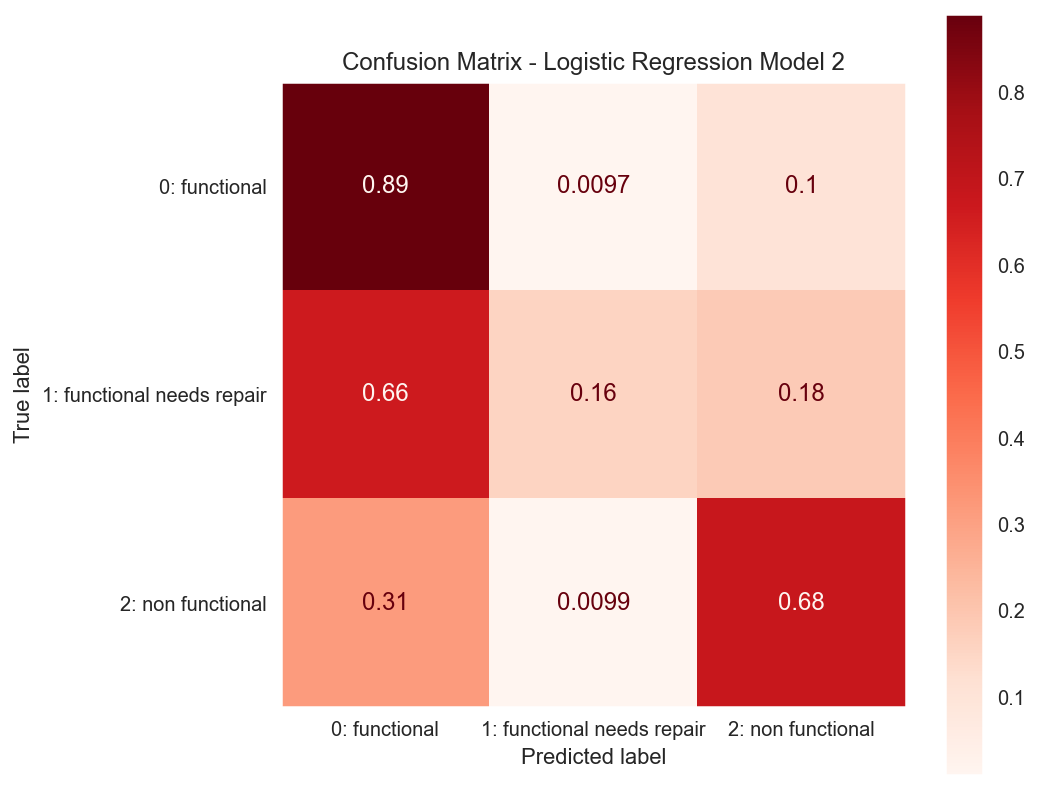



                            precision    recall  f1-score   support

             0: functional      0.742     0.890     0.809     16130
1: functional needs repair      0.555     0.155     0.243      2158
         2: non functional      0.793     0.678     0.731     11412

                  accuracy                          0.755     29700
                 macro avg      0.697     0.574     0.594     29700
              weighted avg      0.748     0.755     0.738     29700



In [47]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(lr_2_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Logistic Regression Model 2')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = lr_2_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - Tuning for regularization strength and max iterations didn't seem to yield us much improvement at all. Our testing accuracy didn't change (rounding to three digits) while our cross-validated accuracy actually fell by an extremely small margin. We'll accept this as our final logistic regression model.

<br>

# Model 2.1: K-Nearest Neighbors

Let's try our next classification model: k-nearest neighbors. In the interest of time, we'll skip the vanilla model and go right to using a GridSearchCV to look for optimal hyperparameters. We'll try out two different `n_neighbors` values and two different `p` values, which is the power parameter for the Minkowski metric. A value of 1 is Manhattan distance while a value of 2 is Euclidean distance.

In [48]:
# steps=[('preprocessing', ct), 
#        ('knn', KNeighborsClassifier())]

# knn_1_pipe = Pipeline(steps)

# pipe_grid = {'knn__n_neighbors': [5, 9], 
#              'knn__p': [1, 2]}

# knn_1_gs_pipe = GridSearchCV(estimator=knn_1_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=5,
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     knn_1_gs_pipe.fit(X_train, y_train.values.ravel())

In [49]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/knn_1_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(knn_1_gs_pipe, f)

In [50]:
# Load in pickled object
with open('pickled_objects/knn_1_gs_pipe.pkl', 'rb') as f:
    knn_1_gs_pipe = joblib.load(f)
    
print(knn_1_gs_pipe.best_params_)

{'knn__n_neighbors': 5, 'knn__p': 1}


In [51]:
# Create KNN classifier model with optimal hyperparameters found above
optimal_n_neighbors = knn_1_gs_pipe.best_params_['knn__n_neighbors']
optimal_p = knn_1_gs_pipe.best_params_['knn__p']

steps=[('preprocessing', ct), 
       ('logreg', KNeighborsClassifier(n_neighbors=optimal_n_neighbors, p=optimal_p))]

knn_1_pipe = Pipeline(steps)

knn_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('logreg', KNeighborsClassifier(p=1))])

In [52]:
print_cv_scores(knn_1_pipe, X_train, y_train)

Training Accuracy: 0.811953
Cross_Val Accuracy: 0.745892
----------------------------------------
Training Macro Precision: 0.771289
Cross_Val Macro Precision: 0.669891
----------------------------------------
Training Macro Recall: 0.67271
Cross_Val Macro Recall: 0.594156
----------------------------------------
Training Macro F1 Score: 0.703443
Cross_Val Macro F1 Score: 0.615584
----------------------------------------
Training Macro AUC Score: 0.927048
Cross_Val Macro AUC Score: 0.817995


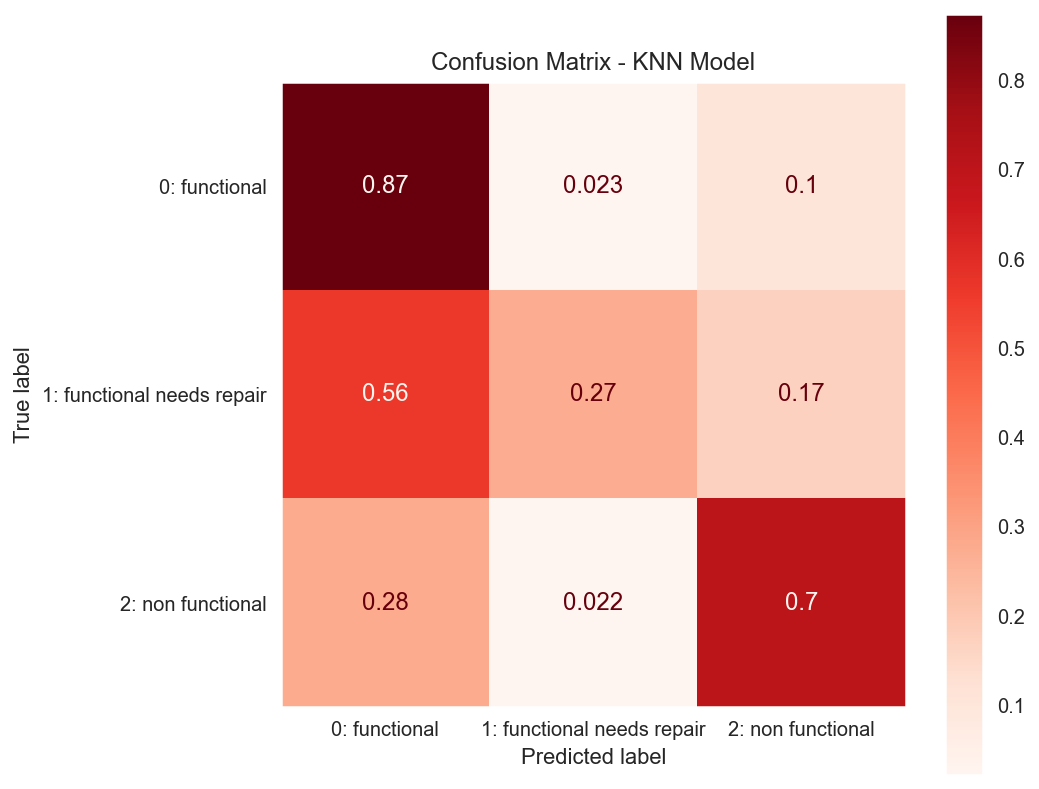



                            precision    recall  f1-score   support

             0: functional      0.764     0.874     0.815     16130
1: functional needs repair      0.486     0.269     0.346      2158
         2: non functional      0.798     0.702     0.747     11412

                  accuracy                          0.764     29700
                 macro avg      0.682     0.615     0.636     29700
              weighted avg      0.757     0.764     0.755     29700



In [53]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(knn_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - KNN Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = knn_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - This KNN classifier performed slightly worse on our cross-validated accuracy score than our logistic regression models, but achieved a better accuracy score on the testing data, by almost a full 1%. This is our best model so far in terms of testing data accuracy score.

<br>

# Model 3.1: Decision Tree, Iteration 1

Let's move on to our next classifier: decision trees. We'll start with a vanilla decision tree model - just the default hyperparameters. Sklearn decision trees are known to overfit by default, so we should expect to do well on the training data but probably not so great on the testing data.

In [54]:
steps=[('preprocessing', ct), 
       ('dt', DecisionTreeClassifier(random_state=42))]

dt_1_pipe = Pipeline(steps)

dt_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [55]:
print_cv_scores(dt_1_pipe, X_train, y_train)

Training Accuracy: 0.956128
Cross_Val Accuracy: 0.736599
----------------------------------------
Training Macro Precision: 0.951724
Cross_Val Macro Precision: 0.622139
----------------------------------------
Training Macro Recall: 0.915261
Cross_Val Macro Recall: 0.609649
----------------------------------------
Training Macro F1 Score: 0.932001
Cross_Val Macro F1 Score: 0.615132
----------------------------------------
Training Macro AUC Score: 0.996457
Cross_Val Macro AUC Score: 0.750107


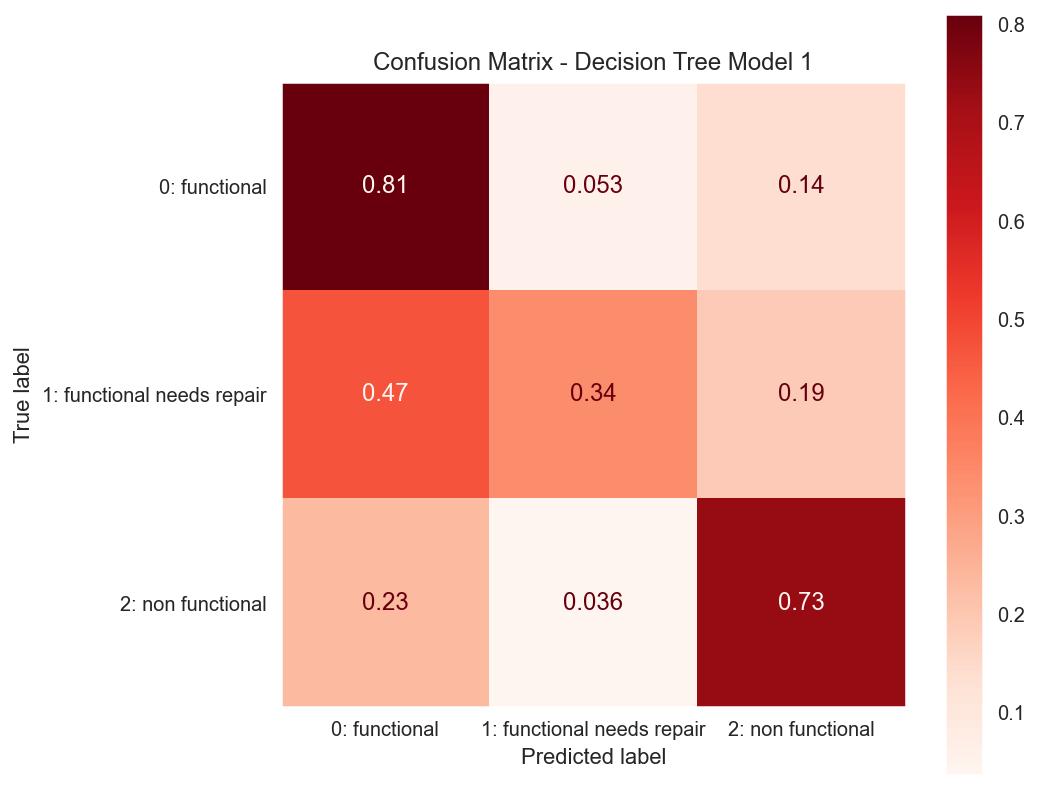



                            precision    recall  f1-score   support

             0: functional      0.782     0.810     0.796     16130
1: functional needs repair      0.367     0.341     0.354      2158
         2: non functional      0.762     0.734     0.748     11412

                  accuracy                          0.747     29700
                 macro avg      0.637     0.628     0.632     29700
              weighted avg      0.744     0.747     0.745     29700



In [56]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(dt_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Decision Tree Model 1')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = dt_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - As expected, the vanilla decision tree model achieved great training scores, but not nearly so great validation scores. It's the worst performing so far on both the cross-validated and testing data.
> 
> - Our baseline decision tree model is clearly overfitting to the training data. Let's try tuning some hyperparameters to see if we can improve performance on the validation / testing data.

<br>

# Model 3.2: Decision Tree, Iteration 2

We saw that the vanilla decision tree model was overfitting to the training data. Let's try tuning some hyperparameters with another GridSearchCV to reduce the overfitting. We'll try to optimize three of the main "pruning" methods of decision trees: `max_depth`, `min_samples_split`, and `min_samples_leaf`.

In [57]:
# steps=[('preprocessing', ct), 
#        ('dt', DecisionTreeClassifier(random_state=42))]

# dt_2_pipe = Pipeline(steps)

# pipe_grid = {'dt__max_depth': [32, 38, 44], 
#              'dt__min_samples_leaf': [5, 6, 7], 
#              'dt__min_samples_split': [2, 3]}

# dt_2_gs_pipe = GridSearchCV(estimator=dt_2_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=5, 
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     dt_2_gs_pipe.fit(X_train, y_train.values.ravel())

In [58]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/dt_2_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(dt_2_gs_pipe, f)

In [59]:
# Load in pickled object
with open('pickled_objects/dt_2_gs_pipe.pkl', 'rb') as f:
    dt_2_gs_pipe = joblib.load(f)
    
print(dt_2_gs_pipe.best_params_)

{'dt__max_depth': 38, 'dt__min_samples_leaf': 6, 'dt__min_samples_split': 2}


In [60]:
# Create new DecisionTree classifier model, with hyperparameters equal to the optimal hyperparameters found 
# with the GridSearchCV above
optimal_max_depth = dt_2_gs_pipe.best_params_['dt__max_depth']
optimal_min_samples_leaf = dt_2_gs_pipe.best_params_['dt__min_samples_leaf']
optimal_min_samples_split = dt_2_gs_pipe.best_params_['dt__min_samples_split']

steps=[('preprocessing', ct), 
       ('dt', DecisionTreeClassifier(max_depth=optimal_max_depth, 
                                     min_samples_leaf=optimal_min_samples_leaf, 
                                     min_samples_split=optimal_min_samples_split, 
                                     random_state=42))]

dt_2_pipe = Pipeline(steps)

dt_2_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('dt',
                 DecisionTreeClassifier(max_depth=38, min_samples_leaf=6,
                                        random_state=42))])

In [61]:
print_cv_scores(dt_2_pipe, X_train, y_train)

Training Accuracy: 0.834537
Cross_Val Accuracy: 0.751448
----------------------------------------
Training Macro Precision: 0.787813
Cross_Val Macro Precision: 0.657768
----------------------------------------
Training Macro Recall: 0.696595
Cross_Val Macro Recall: 0.600094
----------------------------------------
Training Macro F1 Score: 0.726275
Cross_Val Macro F1 Score: 0.61778
----------------------------------------
Training Macro AUC Score: 0.948713
Cross_Val Macro AUC Score: 0.814337


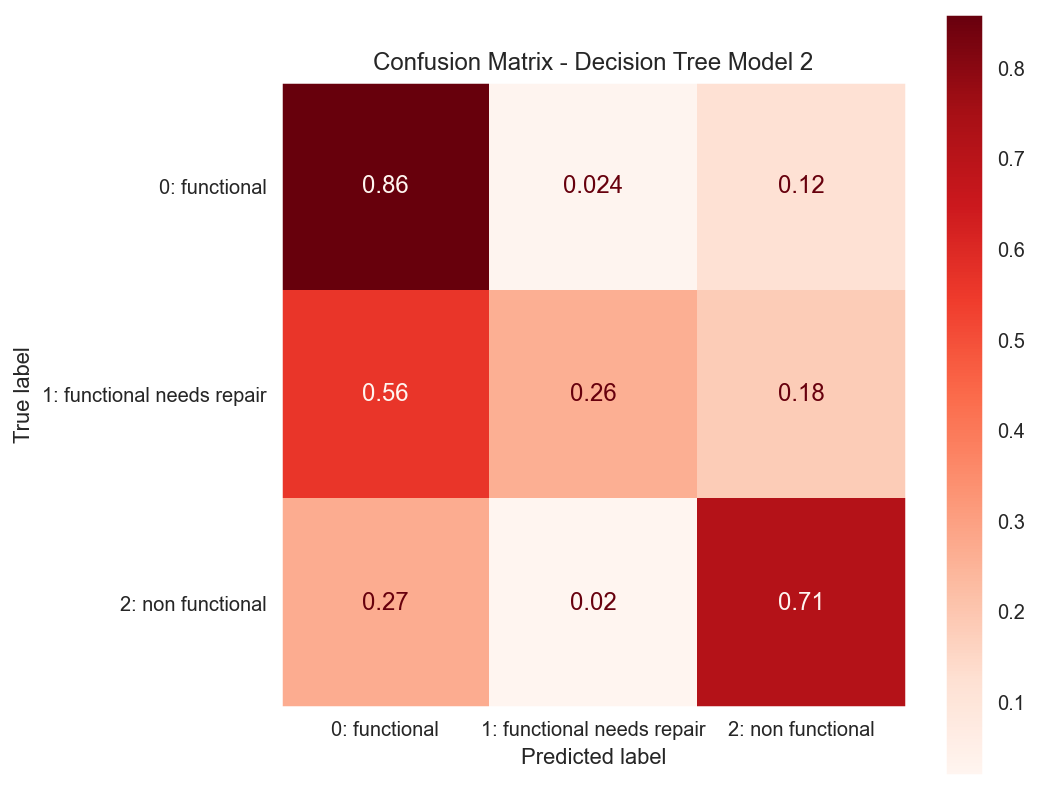



                            precision    recall  f1-score   support

             0: functional      0.764     0.859     0.809     16130
1: functional needs repair      0.479     0.260     0.337      2158
         2: non functional      0.781     0.712     0.745     11412

                  accuracy                          0.759     29700
                 macro avg      0.675     0.610     0.630     29700
              weighted avg      0.750     0.759     0.750     29700



In [62]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(dt_2_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Decision Tree Model 2')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = dt_2_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - As expected our training scores fell by quite a bit, but our validation scores improved modestly from the iteration 1 decision tree classifier. Our cross-validated accuracy is better than the KNN model but worse than the logistic regression models. The KNN model still has the highest testing accuracy score so far.

<br>

# Model 4.1: AdaBoost Classifier

So far we've used logistic regression, KNN, and decision trees as our classification models to classify the water pumps. Let's try using more advanced models now - ensemble methods - to see if we can improve our scores any further. We'll start with an AdaBoost classifier.

In [63]:
# steps=[('preprocessing', ct), 
#        ('ab_clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state = 42))]

# ab_1_pipe = Pipeline(steps)

# pipe_grid = {
#     'ab_clf__n_estimators': [80, 100, 120], 
#     'ab_clf__base_estimator__max_depth': [30, 35, 40]
# }

# ab_1_gs_pipe = GridSearchCV(estimator=ab_1_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=3, # AdaBoost is computationally expensive; reduce cv to 3
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     ab_1_gs_pipe.fit(X_train, y_train.values.ravel())

In [64]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/ab_1_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(ab_1_gs_pipe, f)

In [65]:
# Load in pickled object
with open('pickled_objects/ab_1_gs_pipe.pkl', 'rb') as f:
    ab_1_gs_pipe = joblib.load(f)
    
print(ab_1_gs_pipe.best_params_)

{'ab_clf__base_estimator__max_depth': 35, 'ab_clf__n_estimators': 120}


In [66]:
# Create AdaBoost classifier model with optimal hyperparameters found above
optimal_n_estimators = ab_1_gs_pipe.best_params_['ab_clf__n_estimators']
optimal_max_depth = ab_1_gs_pipe.best_params_['ab_clf__base_estimator__max_depth']

steps=[('preprocessing', ct), 
       ('ab_clf', AdaBoostClassifier(
           n_estimators=optimal_n_estimators, 
           base_estimator=DecisionTreeClassifier(max_depth=optimal_max_depth), 
           random_state = 42))]

ab_1_pipe = Pipeline(steps)

ab_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('ab_clf',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=35),
                                    n_estimators=120, random_state=42))])

In [67]:
print_cv_scores(ab_1_pipe, X_train, y_train)

Training Accuracy: 0.954798
Cross_Val Accuracy: 0.761582
----------------------------------------
Training Macro Precision: 0.943457
Cross_Val Macro Precision: 0.66839
----------------------------------------
Training Macro Recall: 0.919618
Cross_Val Macro Recall: 0.621453
----------------------------------------
Training Macro F1 Score: 0.930834
Cross_Val Macro F1 Score: 0.637745
----------------------------------------
Training Macro AUC Score: 0.994353
Cross_Val Macro AUC Score: 0.826949


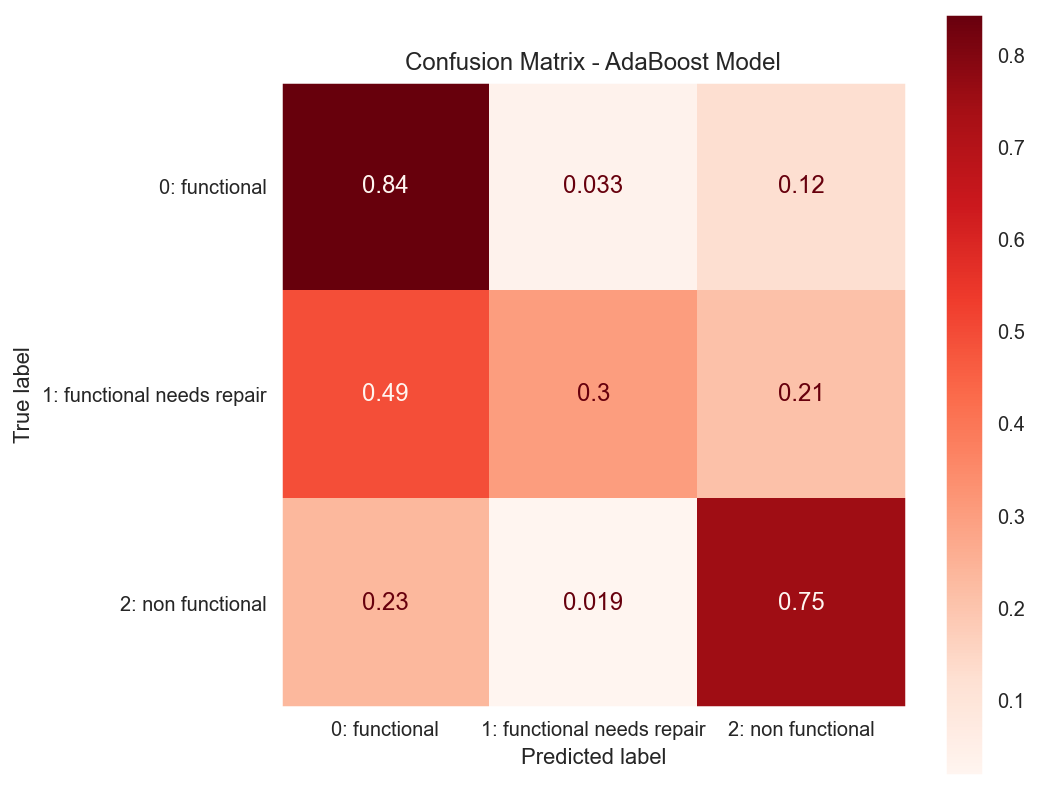



                            precision    recall  f1-score   support

             0: functional      0.786     0.844     0.814     16130
1: functional needs repair      0.465     0.302     0.366      2158
         2: non functional      0.779     0.749     0.764     11412

                  accuracy                          0.768     29700
                 macro avg      0.676     0.632     0.648     29700
              weighted avg      0.760     0.768     0.762     29700



In [68]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(ab_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - AdaBoost Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = ab_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - It looks like our first ensemble method just barely eked out the highest testing accuracy score so far, at 76.8% - that's 0.4% higher than the KNN model. It had a larger margin of improvement on the cross-validated accuracy score at about 1.5%, compared to the KNN model.

<br>

# Model 5.1: Gradient Boosting Classifier

Now we'll try our second ensemble method: a gradient boosting classifier

In [69]:
# steps=[('preprocessing', ct), 
#        ('gb_clf', GradientBoostingClassifier(random_state=42))]

# gb_1_pipe = Pipeline(steps)

# pipe_grid = {
#     'gb_clf__learning_rate': [0.05, 0.1],
#     'gb_clf__n_estimators': [75, 125],
#     'gb_clf__max_depth': [15, 30]
# }

# gb_1_gs_pipe = GridSearchCV(estimator=gb_1_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=3,  # GradientBoost is computationally expensive; reduce cv to 3
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     gb_1_gs_pipe.fit(X_train, y_train.values.ravel())

In [70]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/gb_1_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(gb_1_gs_pipe, f)

In [71]:
# Load in pickled object
with open('pickled_objects/gb_1_gs_pipe.pkl', 'rb') as f:
    gb_1_gs_pipe = joblib.load(f)
    
print(gb_1_gs_pipe.best_params_)

{'gb_clf__learning_rate': 0.05, 'gb_clf__max_depth': 15, 'gb_clf__n_estimators': 75}


In [72]:
# Create GradientBoosting classifier model with optimal hyperparameters found above
optimal_learning_rate = gb_1_gs_pipe.best_params_['gb_clf__learning_rate']
optimal_n_estimators = gb_1_gs_pipe.best_params_['gb_clf__n_estimators']
optimal_max_depth = gb_1_gs_pipe.best_params_['gb_clf__max_depth']

steps=[('preprocessing', ct), 
       ('gb_clf', GradientBoostingClassifier(
           learning_rate=optimal_learning_rate, 
           n_estimators=optimal_n_estimators, 
           max_depth=optimal_max_depth, 
           random_state = 42))]

gb_1_pipe = Pipeline(steps)

gb_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('gb_clf',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=15,
                                            n_estimators=75,
                                            random_state=42))])

In [73]:
print_cv_scores(gb_1_pipe, X_train, y_train)

Training Accuracy: 0.938662
Cross_Val Accuracy: 0.779394
----------------------------------------
Training Macro Precision: 0.939317
Cross_Val Macro Precision: 0.691254
----------------------------------------
Training Macro Recall: 0.877586
Cross_Val Macro Recall: 0.623287
----------------------------------------
Training Macro F1 Score: 0.904039
Cross_Val Macro F1 Score: 0.643594
----------------------------------------
Training Macro AUC Score: 0.991774
Cross_Val Macro AUC Score: 0.86591


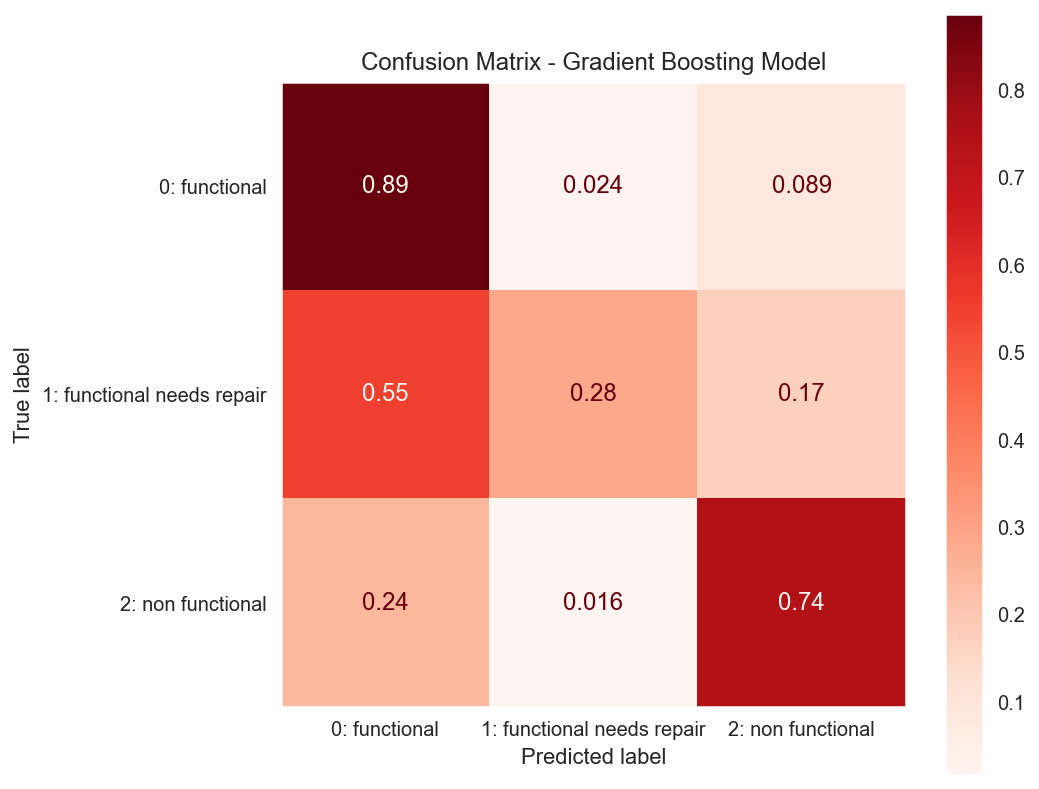



                            precision    recall  f1-score   support

             0: functional      0.784     0.887     0.832     16130
1: functional needs repair      0.514     0.284     0.366      2158
         2: non functional      0.825     0.742     0.781     11412

                  accuracy                          0.787     29700
                 macro avg      0.708     0.638     0.660     29700
              weighted avg      0.780     0.787     0.779     29700



In [74]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(gb_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Gradient Boosting Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = gb_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - It was very computationally expensive to run the GridSearchCV for this GradientBoost, but worth it. This model outperformed all of our previous models by a solid margin. Our cross-validation accuracy just shy of 78%, while our testing accuracy is nearly 79%. Our cross-validated AUC score is over 86% and our weighted average F1 score is over 77%. Our previous best testing accuracy was with the AdaBoost model at 76.8%, so the GradientBoost outperformed our previous best by nearly 2%.

<br>

# Model 6.1: Random Forest Classifier

Now onto our next ensemble method: a random forest classifier

In [75]:
# steps=[('preprocessing', ct), 
#        ('rf_clf', RandomForestClassifier(random_state=42))]

# rf_1_pipe = Pipeline(steps)

# pipe_grid = {
#     'rf_clf__n_estimators': [75, 100, 125],
#     'rf_clf__min_samples_leaf': [2, 3, 4], 
#     'rf_clf__min_samples_split': [4, 6, 8]
# }

# rf_1_gs_pipe = GridSearchCV(estimator=rf_1_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=5,
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     rf_1_gs_pipe.fit(X_train, y_train.values.ravel())

In [76]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/rf_1_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(rf_1_gs_pipe, f)

In [77]:
# Load in pickled object
with open('pickled_objects/rf_1_gs_pipe.pkl', 'rb') as f:
    rf_1_gs_pipe = joblib.load(f)
    
print(rf_1_gs_pipe.best_params_)

{'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 8, 'rf_clf__n_estimators': 125}


In [78]:
# Create RandomForest classifier model with optimal hyperparameters found above
optimal_n_estimators = rf_1_gs_pipe.best_params_['rf_clf__n_estimators']
optimal_min_samples_leaf = rf_1_gs_pipe.best_params_['rf_clf__min_samples_leaf']
optimal_min_samples_split = rf_1_gs_pipe.best_params_['rf_clf__min_samples_split']

steps=[('preprocessing', ct), 
       ('rf_clf', RandomForestClassifier(
           n_estimators=optimal_n_estimators, 
           min_samples_leaf=optimal_min_samples_leaf, 
           min_samples_split=optimal_min_samples_split, 
           random_state = 42))]

rf_1_pipe = Pipeline(steps)

rf_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'public_meeting', 'permit',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])])),
                ('rf_clf',
                 RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                                        n_estimators=125, random_state=42))])

In [79]:
print_cv_scores(rf_1_pipe, X_train, y_train)

Training Accuracy: 0.841717
Cross_Val Accuracy: 0.77798
----------------------------------------
Training Macro Precision: 0.834717
Cross_Val Macro Precision: 0.74701
----------------------------------------
Training Macro Recall: 0.666497
Cross_Val Macro Recall: 0.599579
----------------------------------------
Training Macro F1 Score: 0.699903
Cross_Val Macro F1 Score: 0.624028
----------------------------------------
Training Macro AUC Score: 0.955616
Cross_Val Macro AUC Score: 0.87554


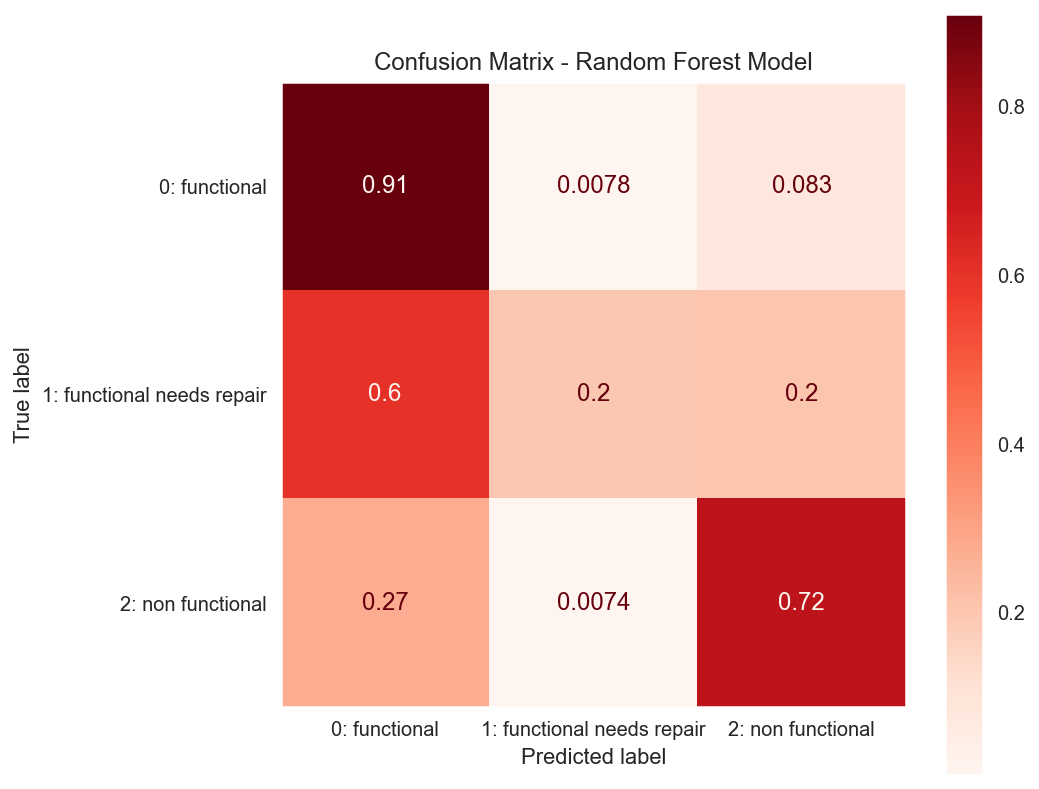



                            precision    recall  f1-score   support

             0: functional      0.770     0.909     0.834     16130
1: functional needs repair      0.668     0.197     0.304      2158
         2: non functional      0.822     0.723     0.769     11412

                  accuracy                          0.786     29700
                 macro avg      0.754     0.610     0.636     29700
              weighted avg      0.783     0.786     0.771     29700



In [80]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(rf_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - Random Forest Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = rf_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

> **Remarks:**
> - Our RandomForest model was much quicker to run than the GradientBoost model, but underperformed it by a miniscule 0.1% on the testing data. It basically tied on the cross-validated accuracy score with GradientBoost, while it got a 0.8% lower weighted average F1 score. Overall, the GradientBoost just barely outperformed the RandomForest, but at a much greater computational cost.

<br>

# Model 7.1: XGBoost Classifier

For our next ensemble method, we're going to use an extreme gradient boost (XGBoost) classifier to see if we can beat out all of our previous models

In [81]:
# steps=[('preprocessing', ct), 
#        ('xgb_clf', XGBClassifier(random_state=42))]

# xgb_1_pipe = Pipeline(steps)

# pipe_grid = {
#     'xgb_clf__learning_rate': [0.05, 0.1],
#     'xgb_clf__max_depth': [20, 30],
#     'xgb_clf__n_estimators': [75, 125],
#     'xgb_clf__gamma': [0, 3]
# }

# xgb_1_gs_pipe = GridSearchCV(estimator=xgb_1_pipe, 
#                             param_grid=pipe_grid, 
#                             cv=3,  # XGBoost is computationally expensive; reduce cv to 3
#                             n_jobs=-1, 
#                             verbose=True)

# with parallel_backend('threading', n_jobs=-1):
#     xgb_1_gs_pipe.fit(X_train, y_train.values.ravel())

In [82]:
# # Pickle GridSearchCV object so we don't have to re-run that cell when reloading notebook
# with open('pickled_objects/xgb_1_gs_pipe.pkl', 'wb') as f:
#     joblib.dump(xgb_1_gs_pipe, f)

In [83]:
# Load in pickled object
with open('pickled_objects/xgb_1_gs_pipe.pkl', 'rb') as f:
    xgb_1_gs_pipe = joblib.load(f)
    
print(xgb_1_gs_pipe.best_params_)

{'xgb_clf__gamma': 3, 'xgb_clf__learning_rate': 0.1, 'xgb_clf__max_depth': 30, 'xgb_clf__n_estimators': 75}


In [84]:
# Create XGBoost classifier model with optimal hyperparameters found above
optimal_learning_rate = xgb_1_gs_pipe.best_params_['xgb_clf__learning_rate']
optimal_max_depth = xgb_1_gs_pipe.best_params_['xgb_clf__max_depth']
optimal_n_estimators = xgb_1_gs_pipe.best_params_['xgb_clf__n_estimators']
optimal_gamma = xgb_1_gs_pipe.best_params_['xgb_clf__gamma']

steps=[('preprocessing', ct), 
       ('xgb_clf', XGBClassifier(
           learning_rate=optimal_learning_rate, 
           max_depth=optimal_max_depth, 
           n_estimators=optimal_n_estimators, 
           gamma=optimal_gamma, 
           random_state = 42))]

xgb_1_pipe = Pipeline(steps)

xgb_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss_pipe',
                                                  Pipeline(steps=[('standard_scale',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'construction_year']),
                                                 ('ohe_pipe',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer...
                               gamma=3, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=30, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=75, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))])

In [85]:
print_cv_scores(xgb_1_pipe, X_train, y_train)

Training Accuracy: 0.844217
Cross_Val Accuracy: 0.784545
----------------------------------------
Training Macro Precision: 0.835863
Cross_Val Macro Precision: 0.744673
----------------------------------------
Training Macro Recall: 0.680066
Cross_Val Macro Recall: 0.61208
----------------------------------------
Training Macro F1 Score: 0.716177
Cross_Val Macro F1 Score: 0.638149
----------------------------------------
Training Macro AUC Score: 0.945932
Cross_Val Macro AUC Score: 0.881653


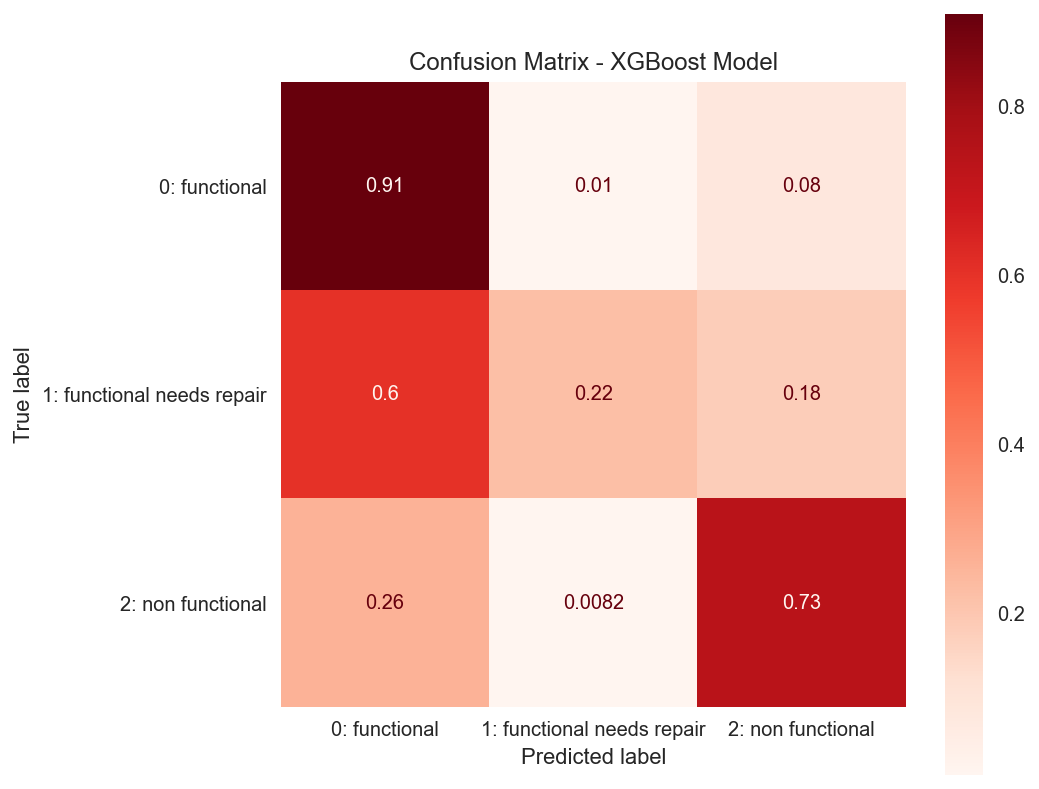



                            precision    recall  f1-score   support

             0: functional      0.776     0.910     0.837     16130
1: functional needs repair      0.652     0.222     0.331      2158
         2: non functional      0.833     0.734     0.780     11412

                  accuracy                          0.792     29700
                 macro avg      0.754     0.622     0.649     29700
              weighted avg      0.789     0.792     0.779     29700



In [106]:
# Set ax size
fig, ax = plt.subplots(figsize=(7, 7))

# Plot confusion matrix on testing data
plot_confusion_matrix(xgb_1_pipe, X_test, y_test, normalize='true', display_labels=class_names, ax=ax, cmap='Reds')
plt.grid(False)
plt.title('Confusion Matrix - XGBoost Model')
plt.show()

# Print classification report on testing data
print('\n')
y_preds = xgb_1_pipe.predict(X_test)
print(classification_report(y_test, y_preds, target_names=class_names, digits=3))

>**Remarks:**
> - The XGBoost model beat out all of our previous models, with a test accuracy score of 79.2%. That's a 0.5% improvement on the previous best, the gradient boosting model.

<br>

# Results and Evaluation

Now let's look at compiled model results, label-level results for our best model, an ROC curve graph for our best model, and feature importances for our best model.

## Dataframe of Compiled Model Results - Accuracy Scores

Training, cross-validation, and test accuracy scores for each model are compiled. Models are sorted by descending test accuracy scores, with training accuracy scores breaking the tie in the case of the logistic regression models.

In [87]:
columns = ['Model', 'Training Accuracy', 'Cross-Validation Accuracy', 'Test Accuracy']

models = ['Model 0: Baseline Dummy', 'Model 1.1: Logistic Regression 1', 'Model 1.2: Logistic Regression 2', 
          'Model 2.1: KNN', 'Model 3.1: Decision Tree 1', 'Model 3.2: Decision Tree 2', 'Model 4.1: AdaBoost', 
          'Model 5.1: Gradient Boosting', 'Model 6.1: Random Forest', 'Model 7.1: XGBoost']

train_accuracy_scores = [0.543, 0.758, 0.759, 0.812, 0.956, 0.835, 0.955, 0.939, 0.842, 0.844]
cv_accuracy_scores = [0.543, 0.752, 0.752, 0.746, 0.737, 0.751, 0.762, 0.779, 0.778, 0.785]
test_accuracy_scores = [0.543, 0.755, 0.755, 0.764, 0.747, 0.759, 0.768, 0.787, 0.786, 0.792]

compiled_acc_scores = list(zip(models, train_accuracy_scores, cv_accuracy_scores, test_accuracy_scores))

compiled_acc_scores_df = pd.DataFrame(compiled_acc_scores, columns=columns)
compiled_acc_scores_df.sort_values(by=['Test Accuracy', 'Training Accuracy'], ascending=False)

,Model,Training Accuracy,Cross-Validation Accuracy,Test Accuracy
9,Model 7.1: XGBoost,0.844,0.785,0.792
7,Model 5.1: Gradient Boosting,0.939,0.779,0.787
8,Model 6.1: Random Forest,0.842,0.778,0.786
6,Model 4.1: AdaBoost,0.955,0.762,0.768
3,Model 2.1: KNN,0.812,0.746,0.764
5,Model 3.2: Decision Tree 2,0.835,0.751,0.759
2,Model 1.2: Logistic Regression 2,0.759,0.752,0.755
1,Model 1.1: Logistic Regression 1,0.758,0.752,0.755
4,Model 3.1: Decision Tree 1,0.956,0.737,0.747
0,Model 0: Baseline Dummy,0.543,0.543,0.543


<br>

## Dataframe of Compiled Model Results - Precision, Recall, F1, and AUC Scores

All scores are macro (unweighted) averages. This is the tougher, more conservative metric as it does not account for the class imbalances in this dataset. The AUC score is a macro one-vs-rest score.

Models are sorted in the same order as the dataframe above, by testing accuracy score.

In [88]:
columns = ['Model', 'Test Precision', 'Test Recall', 'Test F1 Score', 'Cross-Validation AUC Score']

models = ['Model 0: Baseline Dummy', 'Model 1.1: Logistic Regression 1', 'Model 1.2: Logistic Regression 2', 
          'Model 2.1: KNN', 'Model 3.1: Decision Tree 1', 'Model 3.2: Decision Tree 2', 'Model 4.1: AdaBoost', 
          'Model 5.1: Gradient Boosting', 'Model 6.1: Random Forest', 'Model 7.1: XGBoost']

precision_scores = [0.181, 0.702, 0.697, 0.682, 0.637, 0.675, 0.676, 0.708, 0.754, 0.754]
recall_scores = [0.333, 0.573, 0.574, 0.615, 0.628, 0.610, 0.632, 0.638, 0.610, 0.622]
f1_scores = [0.235, 0.593, 0.594, 0.636, 0.632, 0.630, 0.648, 0.660, 0.636, 0.649]
auc_scores = [0.500, 0.846, 0.847, 0.818, 0.750, 0.814, 0.827, 0.866, 0.876, 0.882]

compiled_scores = list(zip(models, precision_scores, recall_scores, f1_scores, auc_scores))

compiled_scores_df = pd.DataFrame(compiled_scores, columns=columns)
compiled_scores_df.sort_index(level=[9, 7, 8, 6, 3, 5, 2, 1, 4, 0], ascending=False)

,Model,Test Precision,Test Recall,Test F1 Score,Cross-Validation AUC Score
9,Model 7.1: XGBoost,0.754,0.622,0.649,0.882
8,Model 6.1: Random Forest,0.754,0.610,0.636,0.876
7,Model 5.1: Gradient Boosting,0.708,0.638,0.660,0.866
6,Model 4.1: AdaBoost,0.676,0.632,0.648,0.827
5,Model 3.2: Decision Tree 2,0.675,0.610,0.630,0.814
4,Model 3.1: Decision Tree 1,0.637,0.628,0.632,0.750
3,Model 2.1: KNN,0.682,0.615,0.636,0.818
2,Model 1.2: Logistic Regression 2,0.697,0.574,0.594,0.847
1,Model 1.1: Logistic Regression 1,0.702,0.573,0.593,0.846
0,Model 0: Baseline Dummy,0.181,0.333,0.235,0.500


<br>

## XGBoost Model Compiled Scores by Class Label

Let's take a look at the best model's metrics by individual class label

In [89]:
columns = ['Class Labal', 'Precision', 'Recall', 'F1 Score', 'Support']

class_labels = ['0: functional', '1: functional needs repair', '2: non functional']

precision_scores = [0.776, 0.652, 0.833]
recall_scores = [0.910, 0.222, 0.734]
f1_scores = [0.837, 0.331, 0.780]
supports = [16130, 2158, 11412]

compiled_metrics = list(zip(class_labels, precision_scores, recall_scores, f1_scores, supports))

compiled_scores_df = pd.DataFrame(compiled_metrics, columns=columns)
print('XGBoost Model Metrics:')
compiled_scores_df

XGBoost Model Metrics:


,Class Labal,Precision,Recall,F1 Score,Support
0,0: functional,0.776,0.910,0.837,16130
1,1: functional needs repair,0.652,0.222,0.331,2158
2,2: non functional,0.833,0.734,0.780,11412


> **Remarks:**
> - We are most precise with non-functional water pumps, which means we have the lowest false positive rate with this class label and we rarely misclassify water pumps as non-functional when that is not their true class label (relatively speaking). We are least precise with functional-needs-repair water pumps.
> - We have the best recall with functional water pumps, which means we have the lowest false negative rate with this class label and we rarely fail to correctly predict these pumps (relatively speaking). We have the worst recall with functional-needs-repair pumps.
> - We have the best F1 score with functional water pumps, and the worst F1 score with functional-needs-repair water pumps.

<br>

## XGBoost Model: ROC Curves by Class Label

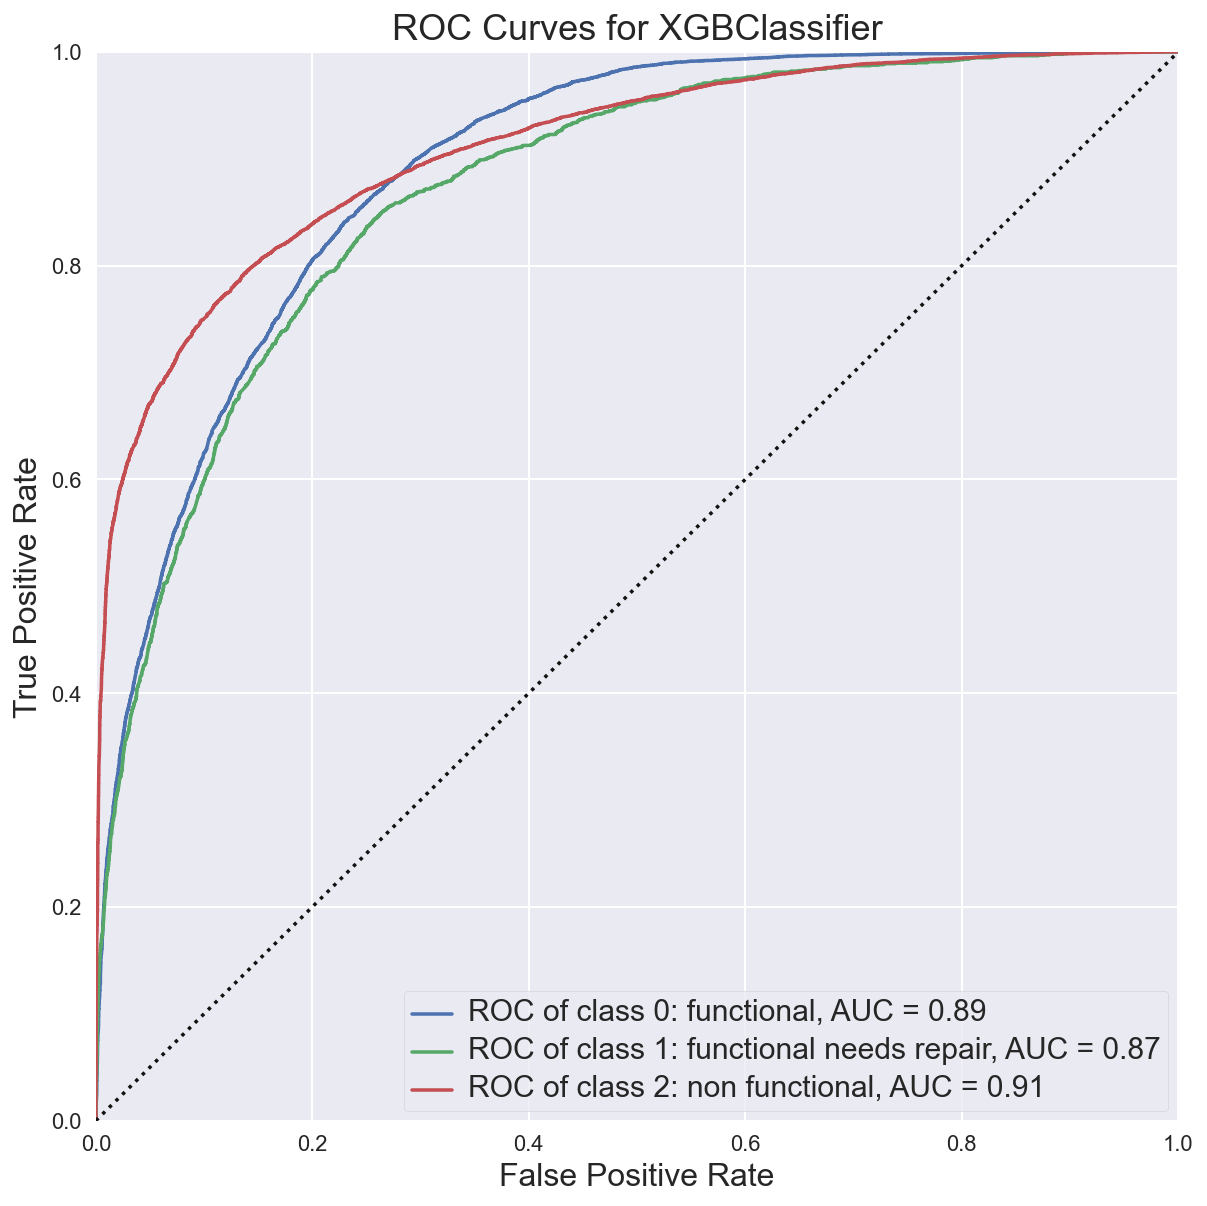

In [105]:
fig, ax = plt.subplots(figsize=(8.5, 8.5))

visualizer = ROCAUC(xgb_1_pipe, 
                    micro=False, 
                    macro=False, 
                    classes=['0: functional', '1: functional needs repair', '2: non functional'])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.finalize()
visualizer.ax.title.set_fontsize(18)   # Increase title fontsize
visualizer.ax.xaxis.label.set_fontsize(16)   # Increase x-axis label fontsize
visualizer.ax.yaxis.label.set_fontsize(16)   # Increase y-axis label fontsize
for text in visualizer.ax.legend_.texts:
     text.set_fontsize(15)   # Increase legend size
for xtick,ytick in zip(visualizer.ax.xaxis.get_major_ticks(),visualizer.ax.yaxis.get_major_ticks()):
    xtick.label.set_fontsize(11)   # Increase xtick label fontsizes
    ytick.label.set_fontsize(11)   # Increase ytick label fontsizes
visualizer.fig.tight_layout()
visualizer.fig.show();

<br>

## XGBoost Top 10 Feature Importances

In [91]:
# Create dataframe of feature importances
feature_importances_df = pd.DataFrame(xgb_1_pipe['xgb_clf'].feature_importances_)
# Set indexes as feature names
feature_importances_df.index = ct.get_feature_names_out()
# Rename column '0' to "Feature Importance"
feature_importances_df.columns = ['Feature Importance']
# Take top 10 features by importance, sorted, and reset the index
feature_importances_df = feature_importances_df.sort_values(axis=0, 
                                                            by='Feature Importance', 
                                                            ascending=False)[:10].reset_index()
# Rename column 'index' to 'Feature'
feature_importances_df = feature_importances_df.rename({'index': 'Feature'}, axis=1)

# Remove "ohe_pipe__" from feature names
for i in feature_importances_df.index:
    feature_importances_df.loc[i, 'Feature'] = feature_importances_df.loc[i, 'Feature'][10:]
    
feature_importances_df

,Feature,Feature Importance
0,waterpoint_type_other,0.121007
1,quantity_seasonal,0.062367
2,quantity_insufficient,0.024206
3,quantity_enough,0.022860
4,lga_Kigoma Rural,0.014499
5,extraction_type_other,0.012994
6,lga_Chunya,0.010459
7,installer_RWE,0.010236
8,region_code_11,0.010187
9,lga_Bariadi,0.009410


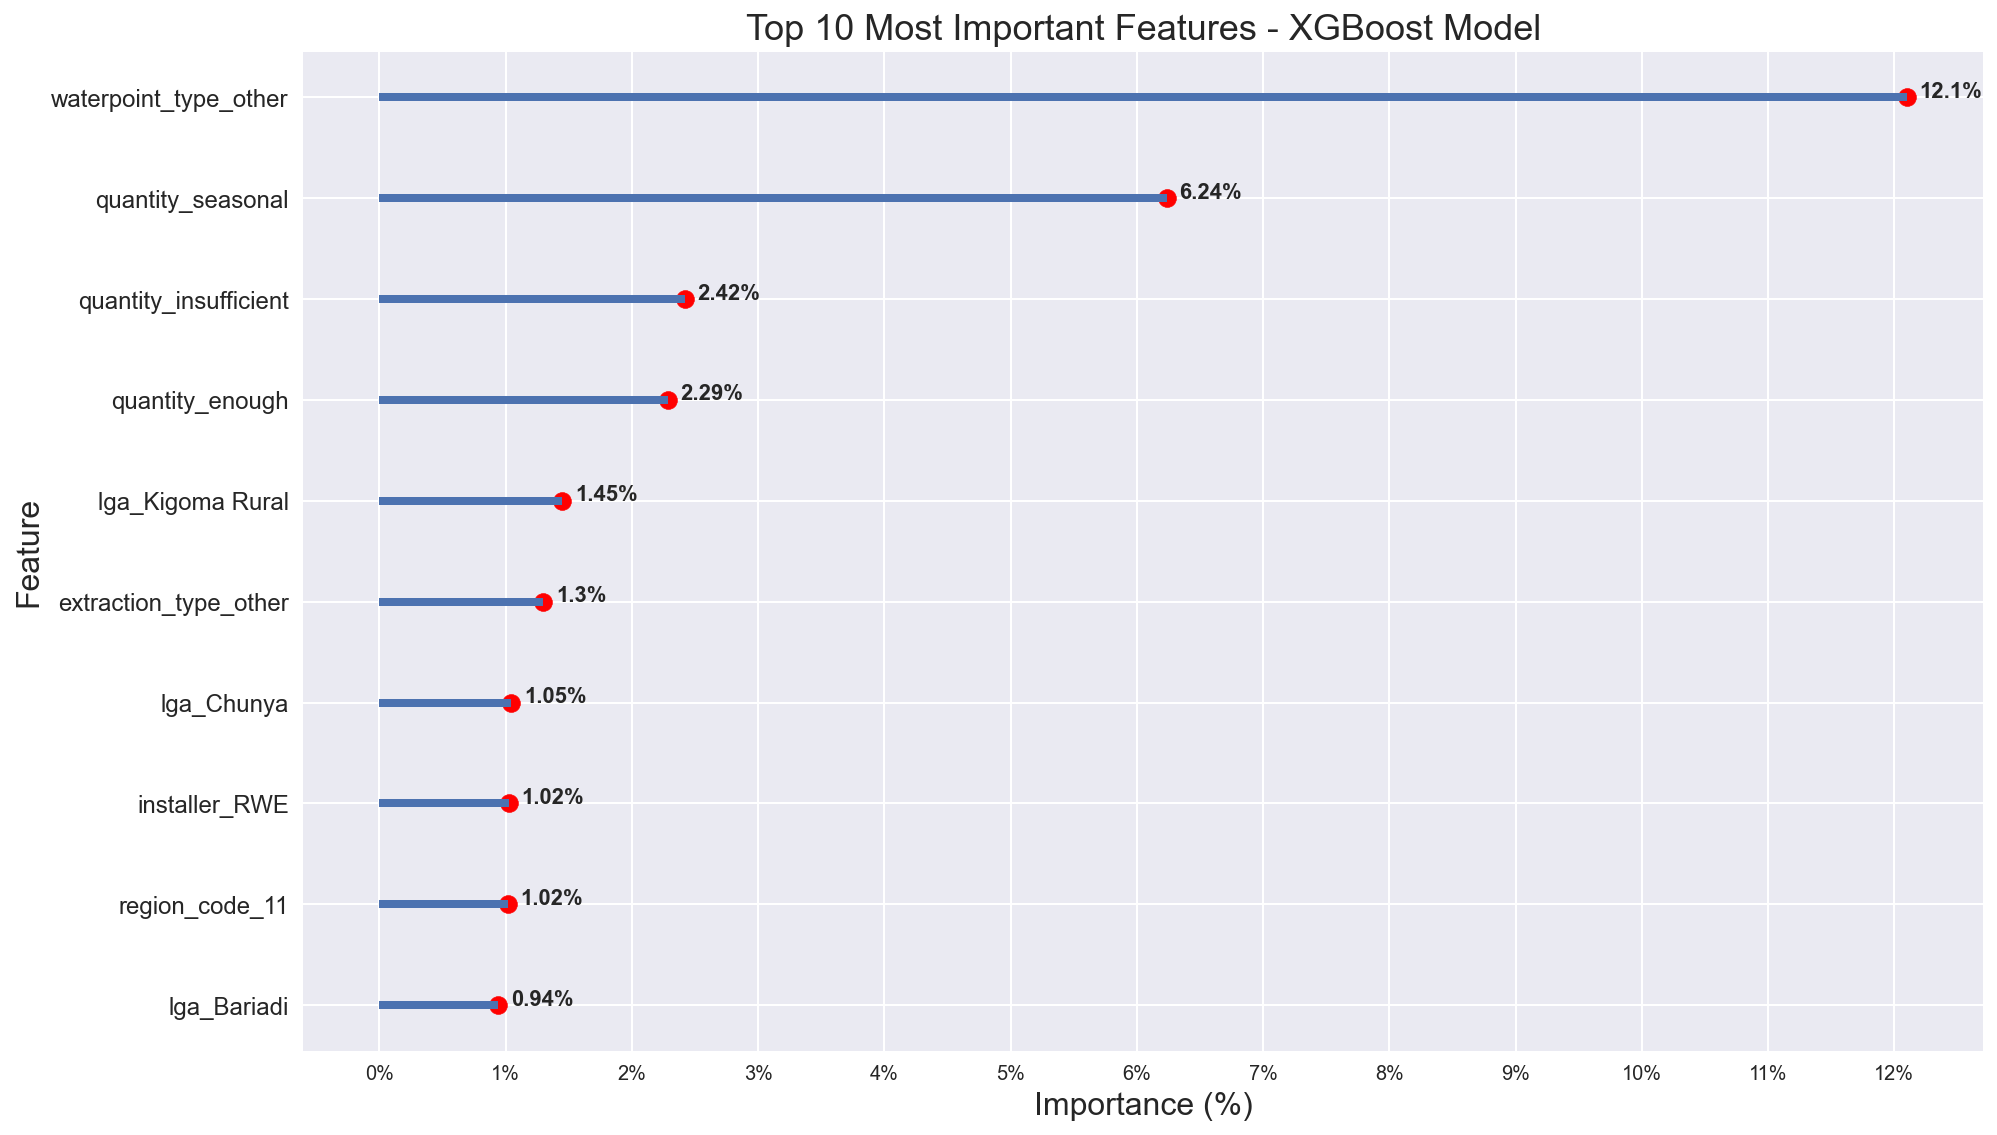

In [107]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot horizontal lines
plt.hlines(feature_importances_df['Feature'].iloc[::-1], linewidths=4, xmin=0, 
           xmax=feature_importances_df['Feature Importance'].iloc[::-1])

# Plot circles
plt.scatter(feature_importances_df['Feature Importance'], feature_importances_df['Feature'],
            color='red', alpha=1, s=80)

# Annotate exact numerical values at end of lines
for idx, row in feature_importances_df.iterrows():
    ax.annotate(f"{round(row['Feature Importance']*100, 2)}%", (row['Feature Importance'], row['Feature']), 
                weight='bold', fontsize=11, 
                xytext=(row['Feature Importance'] + 0.001, row['Feature'])) # offset annotate

plt.title('Top 10 Most Important Features - XGBoost Model', fontsize=18)
plt.xlabel('Importance (%)', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.yticks(fontsize=12)
ax.set_xticks(list(np.arange(0, .13, 0.01)))
ax.set_xticklabels([f"{x}%" for x in range(0, 13)])
plt.tight_layout();

## Class Label Proportions for Each of Top 10 Features

In [93]:
combined_df = X_train_df[['waterpoint_type', 'quantity', 'lga', 'extraction_type', 'installer', 'region_code']].copy()
combined_df = combined_df.join(y_train_df)
combined_df.loc[combined_df['region_code'] == 11]['status_group'].value_counts(normalize=True)

features = []
proportions = []
class_labels = []

for feature in feature_importances_df.Feature.values:
    for i in range(3):
        features.append(feature)

for item in feature_importances_df.Feature.values:
    if item == 'waterpoint_type_other':
        feature = 'waterpoint_type'
        value = 'other'
    elif item == 'extraction_type_other':
        feature = 'extraction_type'
        value = 'other'
    elif item == 'region_code_11':
        feature = 'region_code'
        value = 11
    else:
        feature = item.split('_', 1)[0]
        value = item.split('_', 1)[1]
    for index, value in combined_df.loc[combined_df[feature] == value]['status_group'].value_counts(normalize=True).iteritems():
        proportions.append(value)
        class_labels.append(index)
        
proportions_df = pd.DataFrame(list(zip(features, proportions, class_labels)), 
                              columns=['Feature', 'Proportion', 'Class Label'])

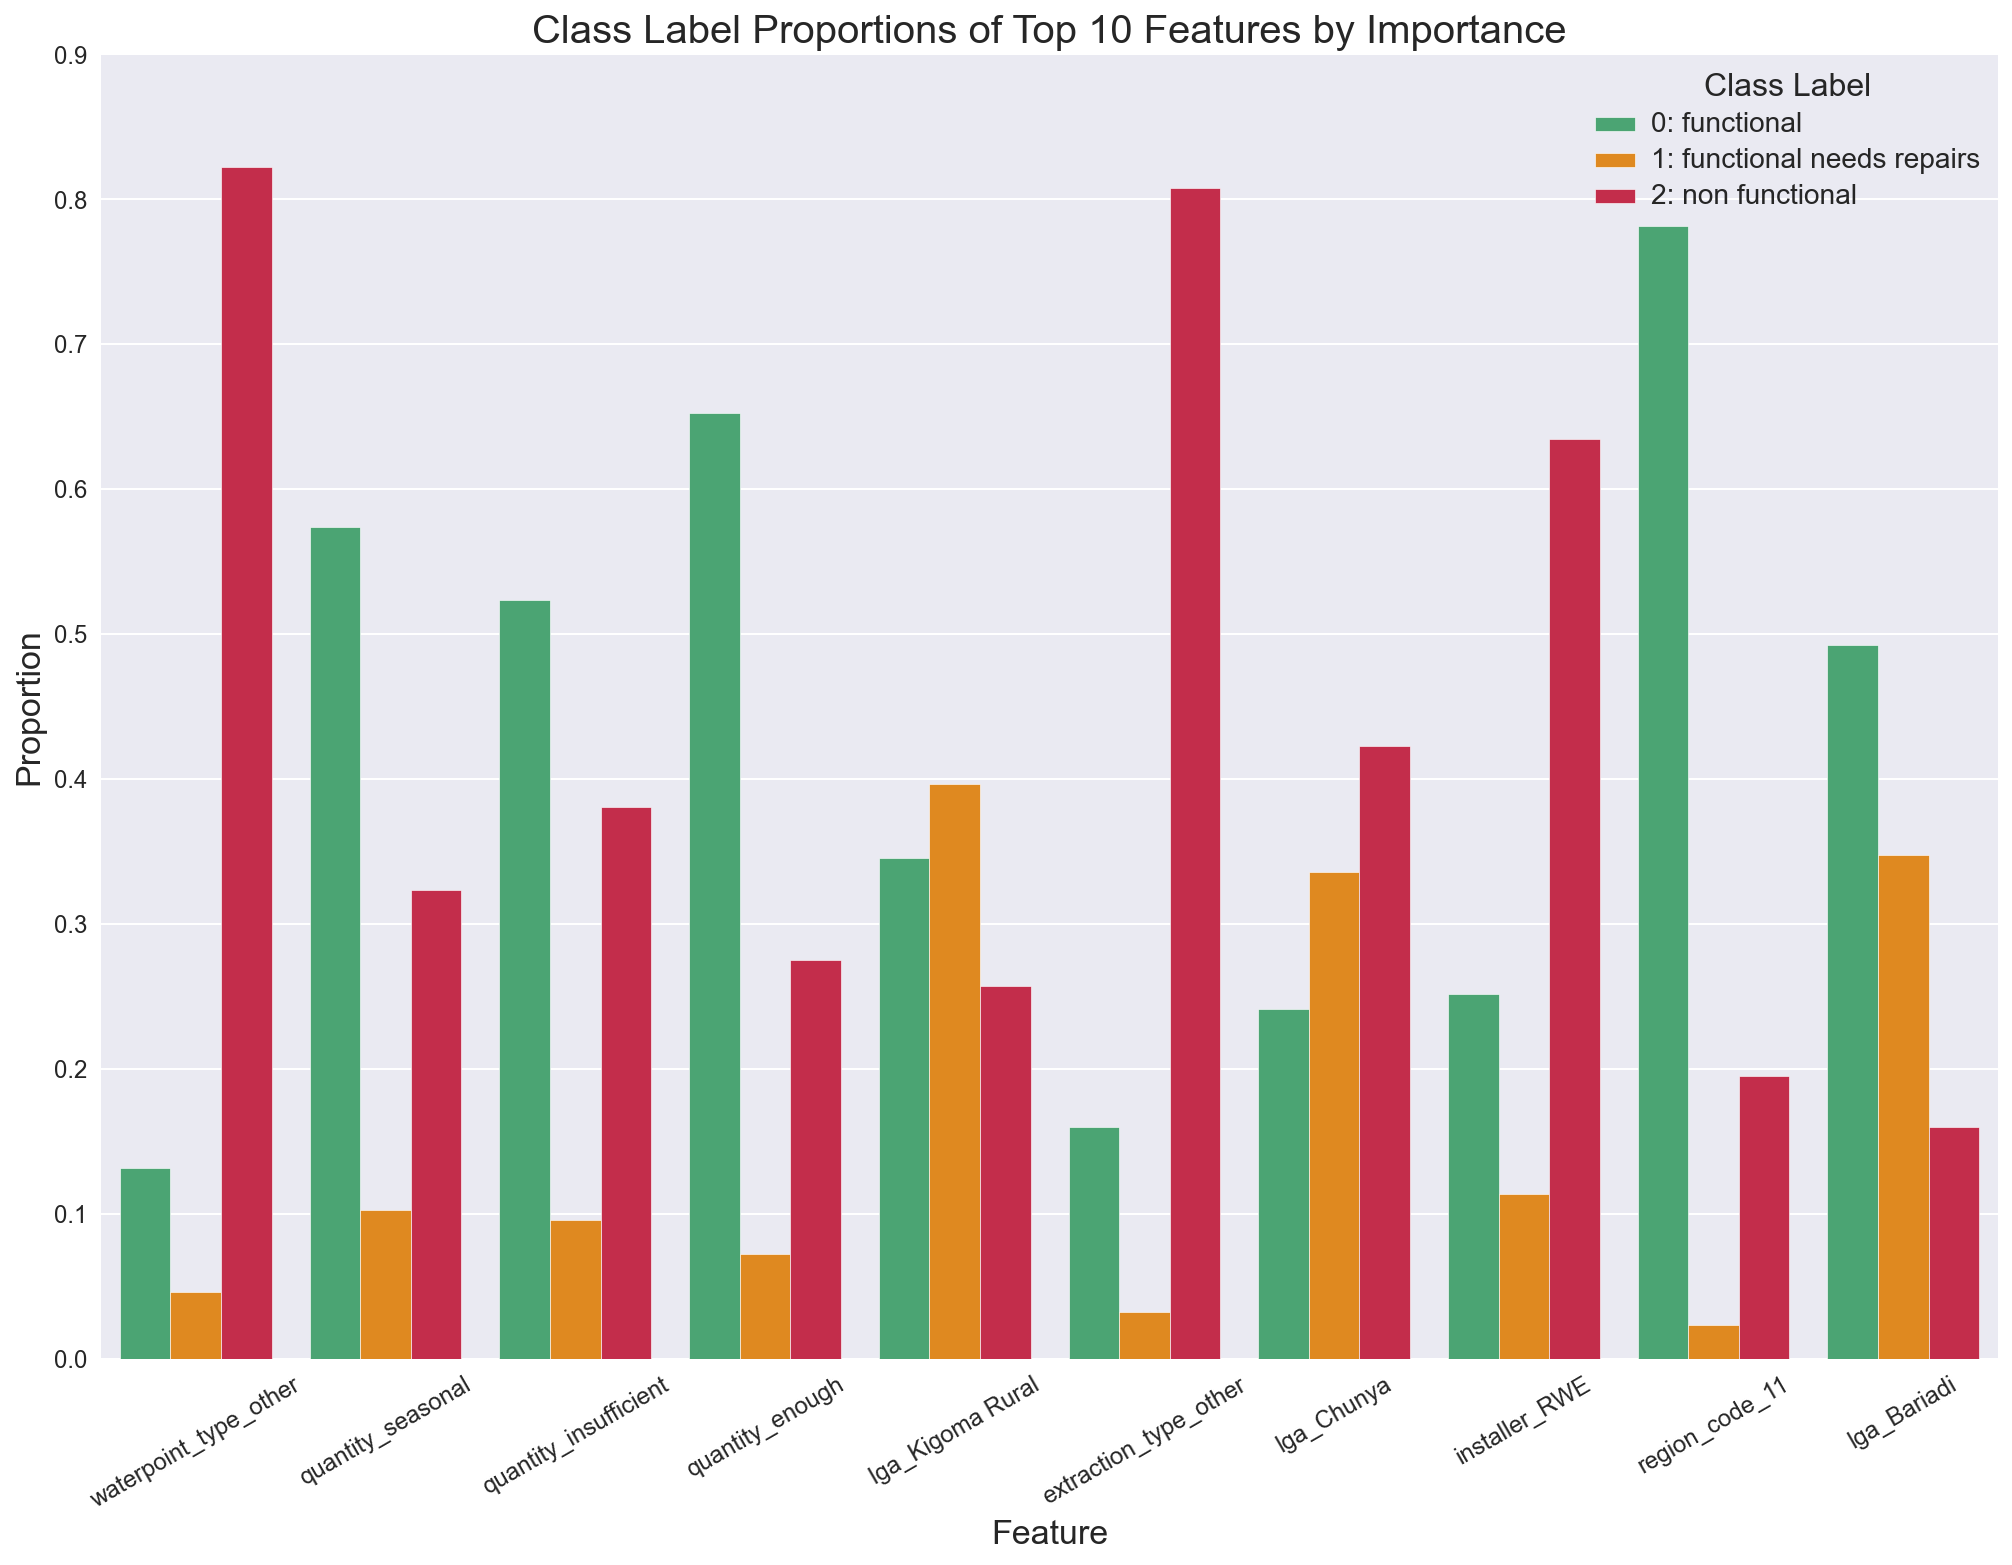

In [142]:
fig, ax = plt.subplots(figsize=(17, 12))

palette = {0: 'mediumseagreen', 1: 'darkorange', 2: 'crimson'}
sns.barplot(x='Feature', y='Proportion', hue='Class Label', data=proportions_df, palette=palette)
plt.title('Class Label Proportions of Top 10 Features by Importance', fontsize=20)
plt.xlabel('Feature', fontsize=17)
plt.ylabel('Proportion', fontsize=17)
plt.xticks(ax.get_xticks(), size=12)
plt.yticks(ax.get_yticks(), size=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
legend=plt.legend(title='Class Label')
legend.get_texts()[0].set_text('0: functional')
legend.get_texts()[1].set_text('1: functional needs repairs')
legend.get_texts()[2].set_text('2: non functional')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.savefig('visualizations/top_10_features_class_proportions_plot.png', dpi=300, bbox_inches='tight')
plt.show();

<br>

# Create `submission` Dataframe for Competition Submission

In [95]:
def preprocess_X_test_df(df):
    df.drop(columns='id', inplace=True)
    columns_to_drop = ['date_recorded', 'longitude', 'latitude', 'num_private', 'region', 'wpt_name', 
                       'subvillage', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
                       'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 
                       'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']
    df.drop(columns=columns_to_drop, inplace=True)
    df['region_code'] = df['region_code'].astype('object')
    df['district_code'] = df['district_code'].astype('object')
    df[['public_meeting', 'permit']] = df[['public_meeting', 'permit']].fillna(value='Unknown')
    df['public_meeting'].replace({False: 'False', True: 'True'}, inplace=True)
    df['permit'].replace({False: 'False', True: 'True'}, inplace=True)
    df['funder'].fillna(value='Other/Unknown', inplace=True)
    df['installer'].fillna(value='Other/Unknown', inplace=True)
    df['funder'].replace(to_replace='0', value='Other/Unknown', inplace=True)
    df['installer'].replace(to_replace='0', value='Other/Unknown', inplace=True)
    funder_indexes = df.funder.value_counts()[50:].index
    installer_indexes = df.installer.value_counts()[50:].index
    df['funder'].replace(to_replace=funder_indexes, value='Other/Unknown', inplace=True)
    df['installer'].replace(to_replace=installer_indexes, value='Other/Unknown', inplace=True)
    linreg_construction_year_0s(df)
    df['gps_height'] = df['gps_height'].apply(lambda x: x + 58)
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: x + 1)
    df['population'] = df['population'].apply(lambda x: x + 1)
    df[['amount_tsh', 'gps_height', 'population']] = \
    df[['amount_tsh', 'gps_height', 'population']].apply(np.log1p)

In [96]:
X_test_df_copy = X_test_df.copy()
preprocess_X_test_df(X_test_df_copy)
submission = pd.DataFrame(xgb_1_pipe.predict(X_test_df_copy), columns=['status_group'])
submission = submission.join(X_test_df.id)
submission = submission.iloc[:, ::-1]
submission

,id,status_group
0,50785,0
1,51630,0
2,17168,0
3,45559,2
4,49871,0
...,...,...
14845,39307,2
14846,18990,0
14847,28749,0
14848,33492,0


# Conclusions, Recommendations, and Next Steps